In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output

## Задача
Предлагаем решить кейс по машинному обучению, связанный с предсказанием трат.

Вам даны транзакции клиентов банка за весь 2019 год с разметкой категориям (Супермаркеты, Фастфуд, Одежда и т.д.)
Задача - предсказать траты этих клиентов по категориям на следующий месяц.

## Ожидаемый результат
Python скрипты или Jupyter ноутбуки с решением (предсказание трат клиентов по каждой категории) + оценка качества полученной модели по выбранной вами метрике.

В этом задании нет цели выбить какой выбить максимально высокий скор, скорее показать ход своего решения.

**КРАЙНЕ ЖЕЛАТЕЛЬНО** как-то использовать текстовые данные. Даже если они не дали значительного прироста, то это все равно можно присылать. Если встроить текстовые данные в обучение основной модели не получилось, но есть какие-то наработки по текстам, их тоже стоит прислать.

**Будет плюсом**:
- хороший аккуратный код
- понятный EDA с пояснениями
- визуализации
- сравнение нескольких подходов
- сравнение вашего финального решение с каким-либо бейзлайном

## Описание данных
- data_train_transactions.csv - покупки клиентов за 2019 год
	- party_rk - уникальный id клиента
	- account_rk - уникальный id счёта
	- transaction_dttm - дата покупки
	- transaction_amt_rur - сумма покупки в рублях
	- category - категория траты
- data_test_transactions.csv - покупки клиентов за январь 2020 года. Для тестирования модели.
- data_party_x_socdem.csv - социально-демографические характеристики клиентов
- data_story_logs.csv - история взаимодействия клиентов с "историями" в приложении банка (лайки, дизлайки). 
	- party_rk - id клиента
	- date_time - дата взаимодействия
	- story_id - уникальный id истории
	- event - реакция клиента на историю (лайк, дизлайк)
- data_story_texts.csv - содержит тексты с историй
	- story_id - уникальный id истории (для матчинга с data_story_logs)
	- name - название истории
	- story_text - текст истории


In [2]:
path_data = '/Users/kolyan/downloads/test_task_for_vtb/data/'

In [36]:
train_trans = pd.read_csv(path_data + 'data_train_transactions.csv')
train_trans.head()

,party_rk,account_rk,financial_account_type_cd,transaction_dttm,transaction_type_desc,transaction_amt_rur,merchant_rk,category
0,51074,54639,2,2019-01-01,Покупка,366.60,146084.0,Супермаркеты
1,1534,5610,2,2019-01-01,Покупка,101.85,166649.0,Супермаркеты
2,60670,68904,2,2019-01-01,Покупка,612.00,1117458.0,Сервисные услуги
3,26389,25082,2,2019-01-01,Покупка,1734.00,123479.0,Красота
4,56812,63010,2,2019-01-01,Покупка,1695.00,988289.0,Разные товары


In [8]:
len(set(train_trans.party_rk.values))

15594

In [3]:
socdem = pd.read_csv(path_data + 'data_party_x_socdem.csv')
print(socdem.shape)
socdem.head()

(50000, 6)


,party_rk,gender_cd,age,marital_status_desc,children_cnt,region_flg
0,61243,F,70.0,NaN,0,0
1,66535,F,25.0,NaN,0,0
2,83721,M,55.0,Женат/замужем,0,0
3,88238,F,35.0,NaN,0,0
4,57179,F,30.0,Женат/замужем,0,0


In [12]:
ds[ds.party_rk == 27765]

,party_rk,account_rk,financial_account_type_cd,transaction_dttm,transaction_type_desc,transaction_amt_rur,merchant_rk,category,gender_cd,age,marital_status_desc,children_cnt,region_flg
1864940,27765,21505,2,2019-01-08,Снятие наличных,3027.00,539482.0,Наличные,M,30.0,NaN,0,0
1864941,27765,21505,2,2019-01-08,Покупка,101.80,44461.0,Одежда/Обувь,M,30.0,NaN,0,0
1864942,27765,21505,2,2019-01-02,Покупка,1196.40,502611.0,Супермаркеты,M,30.0,NaN,0,0
1864943,27765,21505,2,2019-01-04,Покупка,586.74,536012.0,Супермаркеты,M,30.0,NaN,0,0
1864944,27765,21505,2,2019-01-13,Покупка,360.68,535897.0,Супермаркеты,M,30.0,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1865977,27765,21505,2,2019-12-23,Покупка,1310.00,1613810.0,Одежда/Обувь,M,30.0,NaN,0,0
1865978,27765,102895,2,2019-12-23,Покупка,188.71,933456.0,Супермаркеты,M,30.0,NaN,0,0
1865979,27765,102895,2,2019-12-28,Покупка,197.00,2673859.0,Фаст Фуд,M,30.0,NaN,0,0
1865980,27765,21505,2,2019-12-26,Покупка,29.00,1674881.0,Транспорт,M,30.0,NaN,0,0


In [46]:
print(train_trans.shape)
ds = train_trans.merge(socdem, how='inner', on='party_rk')
print(ds.shape)
ds.head()

(4743601, 8)
(4743601, 13)


,party_rk,account_rk,financial_account_type_cd,transaction_dttm,transaction_type_desc,transaction_amt_rur,merchant_rk,category,gender_cd,age,marital_status_desc,children_cnt,region_flg
0,51074,54639,2,2019-01-01,Покупка,366.60,146084.0,Супермаркеты,M,25.0,NaN,0,0
1,51074,54639,2,2019-01-02,Покупка,1713.00,676356.0,Одежда/Обувь,M,25.0,NaN,0,0
2,51074,54639,2,2019-01-16,Покупка,80.80,318893.0,Супермаркеты,M,25.0,NaN,0,0
3,51074,54639,2,2019-01-02,Покупка,2346.00,599200.0,Разные товары,M,25.0,NaN,0,0
4,51074,54639,2,2019-01-18,Покупка,130.12,800756.0,Супермаркеты,M,25.0,NaN,0,0


In [115]:
out = []
user_ids = list(set(ds.party_rk.values))
lenn = len(user_ids)
cnt = 0
for idx in range(len(user_ids)):
    user_df = ds[ds.party_rk == user_ids[idx]]
    months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
    for mon in months:
        mon_df = user_df.iloc[list(np.where(user_df.transaction_dttm.str.contains(f'2019-{mon}'))[0])]

        
        cats = ['Супермаркеты', 'Рестораны', 'Сервисные услуги', 'Одежда/Обувь', 'Транспорт', 'Связь/Телеком', 'Финансовые услуги', 
         'Разные товары', 'Автоуслуги', 'Дом/Ремонт', 'Красота', 'Фаст Фуд', 'Топливо', 'Наличные', 'Аптеки']
        #print(cats)
        for i in range(len(cats)):
            sub = mon_df[mon_df.category == cats[i]]
            count = sub.shape[0]
            summa = sum(sub.transaction_amt_rur.values)
            #print(cats[i], summa)
            out.append({
                'party_rk': user_ids[idx],
                'date': f'2019-{mon}',
                'category': cats[i],
                'count_tr': count,
                'summ': summa
            })
            clear_output(wait=True)
            print(f'Done {idx} user ids from {lenn}')
            print(len(out))

Done 15593 user ids from 15594
2806920


In [116]:
us_mon_df = pd.DataFrame(out)
us_mon_df

,party_rk,date,category,count_tr,summ
0,65536,2019-01,Супермаркеты,5,2729.53
1,65536,2019-01,Рестораны,0,0.00
2,65536,2019-01,Сервисные услуги,0,0.00
3,65536,2019-01,Одежда/Обувь,1,233.00
4,65536,2019-01,Транспорт,0,0.00
...,...,...,...,...,...
2806915,32762,2019-12,Красота,0,0.00
2806916,32762,2019-12,Фаст Фуд,0,0.00
2806917,32762,2019-12,Топливо,0,0.00
2806918,32762,2019-12,Наличные,0,0.00


In [117]:
df = us_mon_df

In [118]:
df.to_csv(path_data + 'mixed_add.csv', index=False)

In [98]:
df = us_mon_df.merge(socdem, how='inner', on='party_rk')

In [123]:
aa = list(set(df.date.values))
aa.sort()
aa

['2019-01',
 '2019-02',
 '2019-03',
 '2019-04',
 '2019-05',
 '2019-06',
 '2019-07',
 '2019-08',
 '2019-09',
 '2019-10',
 '2019-11',
 '2019-12']

In [ ]:
cats = ['Супермаркеты', 'Рестораны', 'Сервисные услуги', 'Одежда/Обувь', 'Транспорт', 'Связь/Телеком', 'Финансовые услуги', 
         'Разные товары', 'Автоуслуги', 'Дом/Ремонт', 'Красота', 'Фаст Фуд', 'Топливо', 'Наличные', 'Аптеки']


In [162]:
def for_one(subb):
    out_d = {}
    base_d = {
        'party_rk': subb.party_rk.values[0],
        'start': min(subb.date.values),
        'end': max(subb.date.values)
    }
    output = []
    for item in cats:
        cc = sum(subb[(subb.category == item) & (subb.date < base_d['end'])].count_tr.values)
        base_d[f'{item}'] = cc
    for item in cats:
        sums = subb[subb.category == item].summ.values
        out_d = base_d.copy()
        out_d['cur_CAT'] = item  # текущая категория
        for i in range(len(sums)):
            if i == len(sums) - 1:
                out_d['label'] = sums[i]
            else:
                out_d[f'spends_mon{i}'] = sums[i]
        output.append(out_d)
    return output
pd.DataFrame(for_one(subb))

,party_rk,start,end,Супермаркеты,Рестораны,Сервисные услуги,Одежда/Обувь,Транспорт,Связь/Телеком,Финансовые услуги,...,cur_CAT,spends_mon0,spends_mon1,spends_mon2,spends_mon3,spends_mon4,spends_mon5,spends_mon6,spends_mon7,label
0,32762,2019-01,2019-09,49,0,1,0,0,2,11,...,Супермаркеты,12828.69,3753.27,710.39,1506.00,445.09,1082.96,895.93,869.93,453.00
1,32762,2019-01,2019-09,49,0,1,0,0,2,11,...,Рестораны,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,32762,2019-01,2019-09,49,0,1,0,0,2,11,...,Сервисные услуги,0.00,0.00,3567.00,0.00,0.00,0.00,0.00,0.00,0.00
3,32762,2019-01,2019-09,49,0,1,0,0,2,11,...,Одежда/Обувь,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,32762,2019-01,2019-09,49,0,1,0,0,2,11,...,Транспорт,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,32762,2019-01,2019-09,49,0,1,0,0,2,11,...,Связь/Телеком,762.00,714.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6,32762,2019-01,2019-09,49,0,1,0,0,2,11,...,Финансовые услуги,3900.00,5694.00,6915.00,7000.00,7000.00,0.00,17979.00,7015.00,7022.00
7,32762,2019-01,2019-09,49,0,1,0,0,2,11,...,Разные товары,490.00,476.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
8,32762,2019-01,2019-09,49,0,1,0,0,2,11,...,Автоуслуги,0.00,766.80,0.00,0.00,0.00,0.00,495.30,0.00,0.00
9,32762,2019-01,2019-09,49,0,1,0,0,2,11,...,Дом/Ремонт,6686.30,14378.18,0.00,1991.28,2475.51,1260.92,2225.25,1124.53,1954.78


In [171]:
mns = 8
final = []
ids = list(set(df.party_rk.values))
len_ids = len(ids)
for i in range(mns, len(aa)):
    print(f'{aa[i-mns]} - {aa[i-1]}  eval {aa[i]}')
    sub_df = df[(df.date >= f'{aa[i-mns]}') & (df.date <= f'{aa[i]}')]
    
    for id_ in ids:
        final.extend(for_one(sub_df[sub_df['party_rk'] == id_]))


2019-01 - 2019-08  eval 2019-09
2019-02 - 2019-09  eval 2019-10
2019-03 - 2019-10  eval 2019-11
2019-04 - 2019-11  eval 2019-12


In [172]:
train_data = pd.DataFrame(final)
print(train_data.shape)
train_data

(935640, 28)


,party_rk,start,end,Супермаркеты,Рестораны,Сервисные услуги,Одежда/Обувь,Транспорт,Связь/Телеком,Финансовые услуги,...,cur_CAT,spends_mon0,spends_mon1,spends_mon2,spends_mon3,spends_mon4,spends_mon5,spends_mon6,spends_mon7,label
0,65536,2019-01,2019-09,138,5,0,7,16,6,1,...,Супермаркеты,2729.53,11772.33,15673.71,8362.35,4975.01,3880.14,1385.55,682.41,586.27
1,65536,2019-01,2019-09,138,5,0,7,16,6,1,...,Рестораны,0.00,0.00,191.00,186.00,0.00,2054.00,0.00,0.00,0.00
2,65536,2019-01,2019-09,138,5,0,7,16,6,1,...,Сервисные услуги,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,65536,2019-01,2019-09,138,5,0,7,16,6,1,...,Одежда/Обувь,233.00,2983.00,634.00,0.00,0.00,0.00,0.00,0.00,0.00
4,65536,2019-01,2019-09,138,5,0,7,16,6,1,...,Транспорт,0.00,280.00,450.00,35.00,0.00,35.00,105.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
935635,32762,2019-04,2019-12,20,0,0,0,0,0,14,...,Красота,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
935636,32762,2019-04,2019-12,20,0,0,0,0,0,14,...,Фаст Фуд,0.00,0.00,0.00,92.00,0.00,0.00,0.00,0.00,0.00
935637,32762,2019-04,2019-12,20,0,0,0,0,0,14,...,Топливо,0.00,0.00,0.00,1686.00,0.00,420.00,0.00,1030.00,0.00
935638,32762,2019-04,2019-12,20,0,0,0,0,0,14,...,Наличные,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [173]:
train_data.to_csv(path_data + 'train_data.csv', index=False)

In [247]:
train_data = pd.read_csv(path_data + 'train_data.csv')
print(train_data.shape)
train_data.head()

(935640, 28)


,party_rk,start,end,Супермаркеты,Рестораны,Сервисные услуги,Одежда/Обувь,Транспорт,Связь/Телеком,Финансовые услуги,...,cur_CAT,spends_mon0,spends_mon1,spends_mon2,spends_mon3,spends_mon4,spends_mon5,spends_mon6,spends_mon7,label
0,65536,2019-01,2019-09,138,5,0,7,16,6,1,...,Супермаркеты,2729.53,11772.33,15673.71,8362.35,4975.01,3880.14,1385.55,682.41,586.27
1,65536,2019-01,2019-09,138,5,0,7,16,6,1,...,Рестораны,0.00,0.00,191.00,186.00,0.00,2054.00,0.00,0.00,0.00
2,65536,2019-01,2019-09,138,5,0,7,16,6,1,...,Сервисные услуги,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,65536,2019-01,2019-09,138,5,0,7,16,6,1,...,Одежда/Обувь,233.00,2983.00,634.00,0.00,0.00,0.00,0.00,0.00,0.00
4,65536,2019-01,2019-09,138,5,0,7,16,6,1,...,Транспорт,0.00,280.00,450.00,35.00,0.00,35.00,105.00,0.00,0.00


In [248]:
train_data = train_data.merge(socdem, how='inner', on='party_rk')
train_data

,party_rk,start,end,Супермаркеты,Рестораны,Сервисные услуги,Одежда/Обувь,Транспорт,Связь/Телеком,Финансовые услуги,...,spends_mon4,spends_mon5,spends_mon6,spends_mon7,label,gender_cd,age,marital_status_desc,children_cnt,region_flg
0,65536,2019-01,2019-09,138,5,0,7,16,6,1,...,4975.01,3880.14,1385.55,682.41,586.27,M,35.0,Холост/не замужем,1,0
1,65536,2019-01,2019-09,138,5,0,7,16,6,1,...,0.00,2054.00,0.00,0.00,0.00,M,35.0,Холост/не замужем,1,0
2,65536,2019-01,2019-09,138,5,0,7,16,6,1,...,0.00,0.00,0.00,0.00,0.00,M,35.0,Холост/не замужем,1,0
3,65536,2019-01,2019-09,138,5,0,7,16,6,1,...,0.00,0.00,0.00,0.00,0.00,M,35.0,Холост/не замужем,1,0
4,65536,2019-01,2019-09,138,5,0,7,16,6,1,...,0.00,35.00,105.00,0.00,0.00,M,35.0,Холост/не замужем,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
935635,32762,2019-04,2019-12,20,0,0,0,0,0,14,...,0.00,0.00,0.00,0.00,0.00,M,50.0,Женат/замужем,0,0
935636,32762,2019-04,2019-12,20,0,0,0,0,0,14,...,0.00,0.00,0.00,0.00,0.00,M,50.0,Женат/замужем,0,0
935637,32762,2019-04,2019-12,20,0,0,0,0,0,14,...,0.00,420.00,0.00,1030.00,0.00,M,50.0,Женат/замужем,0,0
935638,32762,2019-04,2019-12,20,0,0,0,0,0,14,...,0.00,0.00,0.00,0.00,0.00,M,50.0,Женат/замужем,0,0


In [199]:
train_data.columns

Index(['party_rk', 'start', 'end', 'Супермаркеты', 'Рестораны',
       'Сервисные услуги', 'Одежда/Обувь', 'Транспорт', 'Связь/Телеком',
       'Финансовые услуги', 'Разные товары', 'Автоуслуги', 'Дом/Ремонт',
       'Красота', 'Фаст Фуд', 'Топливо', 'Наличные', 'Аптеки', 'cur_CAT',
       'spends_mon0', 'spends_mon1', 'spends_mon2', 'spends_mon3',
       'spends_mon4', 'spends_mon5', 'spends_mon6', 'spends_mon7', 'label',
       'gender_cd', 'age', 'marital_status_desc', 'children_cnt',
       'region_flg'],
      dtype='object')

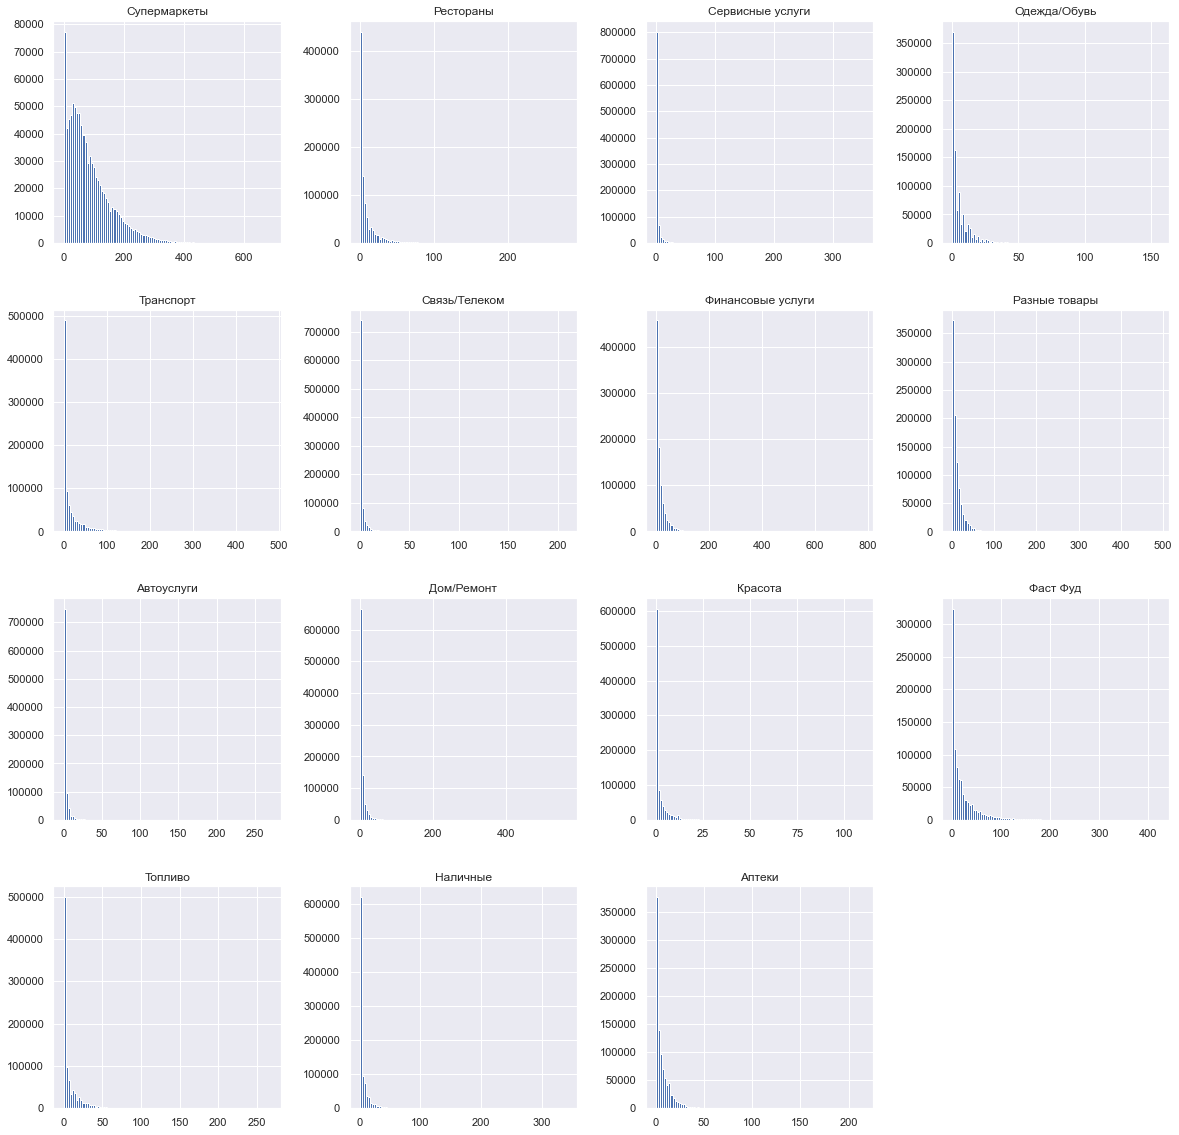

In [249]:
columns_to_draw = ['Супермаркеты', 'Рестораны',
       'Сервисные услуги', 'Одежда/Обувь', 'Транспорт', 'Связь/Телеком',
       'Финансовые услуги', 'Разные товары', 'Автоуслуги', 'Дом/Ремонт',
       'Красота', 'Фаст Фуд', 'Топливо', 'Наличные', 'Аптеки']
xx = train_data[columns_to_draw].hist(bins=100, figsize=(20,20))

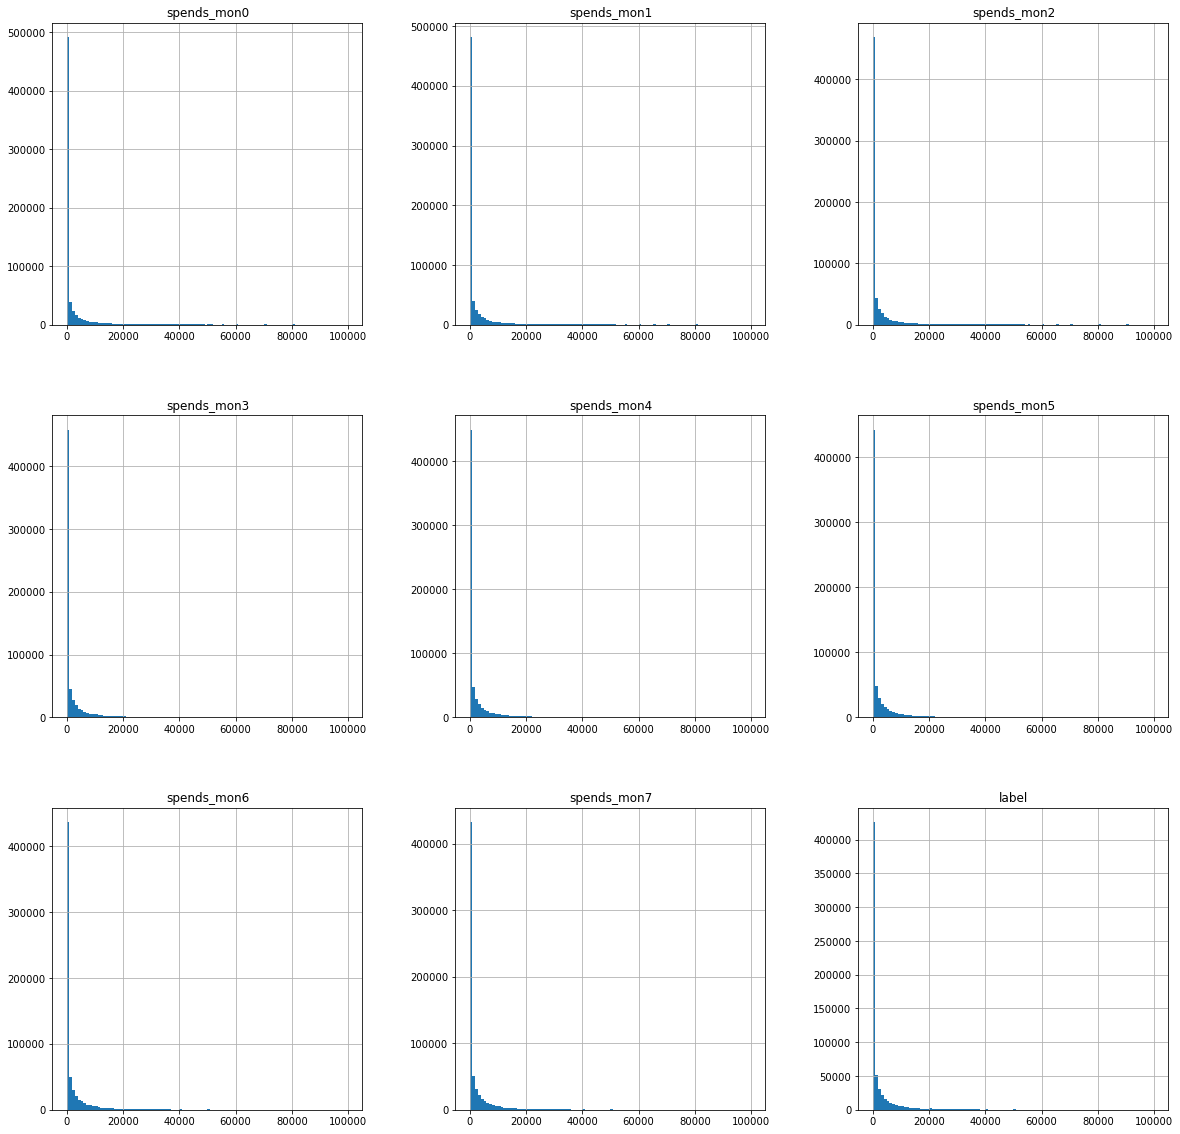

In [214]:
columns_to_draw = ['spends_mon0', 'spends_mon1', 'spends_mon2', 'spends_mon3',
       'spends_mon4', 'spends_mon5', 'spends_mon6', 'spends_mon7', 'label']
subb = train_data[~((train_data.spends_mon0 == 0) & (train_data.spends_mon1 == 0) & (train_data.spends_mon2 == 0)
           & (train_data.spends_mon3 == 0) & (train_data.spends_mon4 == 0) & 
          (train_data.spends_mon5 == 0) & (train_data.spends_mon6 == 0) & (train_data.spends_mon7 == 0) & (train_data.label == 0))]
xx = subb[columns_to_draw].hist(bins=100, figsize=(20,20), range=(0,100000))

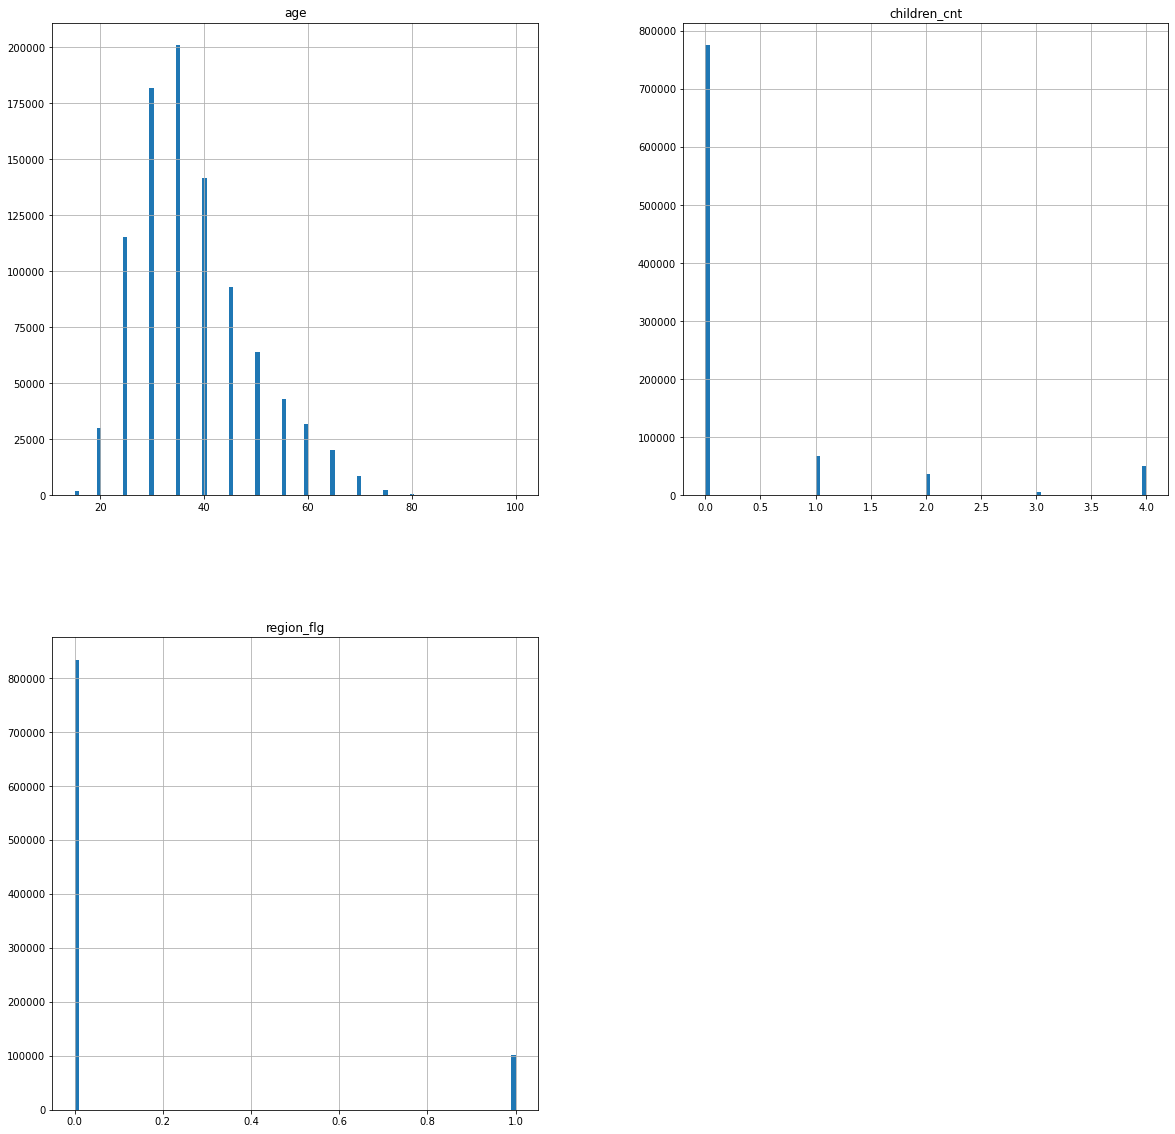

In [215]:
columns_to_draw = ['gender_cd', 'age', 'marital_status_desc', 'children_cnt',
       'region_flg']
xx = train_data[columns_to_draw].hist(bins=100, figsize=(20,20))

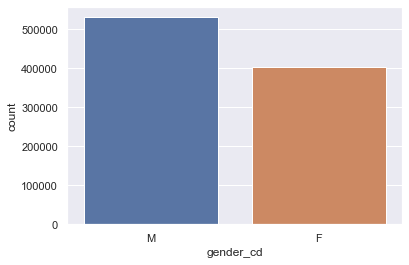

In [239]:
ax = sns.countplot(x="gender_cd", data=train_data)

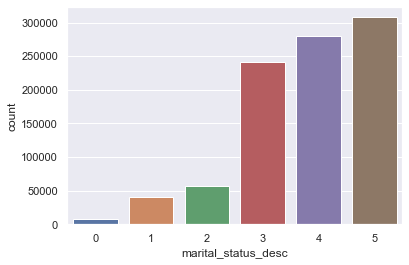

In [252]:

ax = sns.countplot(x="marital_status_desc", data=train_data)

In [219]:
train_data.head()

,party_rk,start,end,Супермаркеты,Рестораны,Сервисные услуги,Одежда/Обувь,Транспорт,Связь/Телеком,Финансовые услуги,...,spends_mon4,spends_mon5,spends_mon6,spends_mon7,label,gender_cd,age,marital_status_desc,children_cnt,region_flg
0,65536,2019-01,2019-09,138,5,0,7,16,6,1,...,4975.01,3880.14,1385.55,682.41,586.27,M,35.0,Холост/не замужем,1,0
1,65536,2019-01,2019-09,138,5,0,7,16,6,1,...,0.00,2054.00,0.00,0.00,0.00,M,35.0,Холост/не замужем,1,0
2,65536,2019-01,2019-09,138,5,0,7,16,6,1,...,0.00,0.00,0.00,0.00,0.00,M,35.0,Холост/не замужем,1,0
3,65536,2019-01,2019-09,138,5,0,7,16,6,1,...,0.00,0.00,0.00,0.00,0.00,M,35.0,Холост/не замужем,1,0
4,65536,2019-01,2019-09,138,5,0,7,16,6,1,...,0.00,35.00,105.00,0.00,0.00,M,35.0,Холост/не замужем,1,0


In [226]:
train_data.columns

Index(['party_rk', 'start', 'end', 'Супермаркеты', 'Рестораны',
       'Сервисные услуги', 'Одежда/Обувь', 'Транспорт', 'Связь/Телеком',
       'Финансовые услуги', 'Разные товары', 'Автоуслуги', 'Дом/Ремонт',
       'Красота', 'Фаст Фуд', 'Топливо', 'Наличные', 'Аптеки', 'cur_CAT',
       'spends_mon0', 'spends_mon1', 'spends_mon2', 'spends_mon3',
       'spends_mon4', 'spends_mon5', 'spends_mon6', 'spends_mon7', 'label',
       'gender_cd', 'age', 'marital_status_desc', 'children_cnt',
       'region_flg'],
      dtype='object')

In [251]:
def gender(x):
    return 1 if x == 'M' else 0
def mart(x):
    if x == 'Вдовец, вдова':
        return 0
    elif x == 'Гражданский брак':
        return 1
    elif x == 'Разведен (а)':
        return 2
    elif x == 'Холост/не замужем':
        return 3
    elif x == 'Женат/замужем':
        return 4
    else:
        return 5
    
train_data['gender_cd'] = train_data['gender_cd'].apply(gender)
train_data['marital_status_desc'] = train_data['marital_status_desc'].apply(mart)

In [253]:
train_data = pd.get_dummies(train_data,columns=['cur_CAT'], prefix='cur_cat')

In [255]:
train_data.to_csv(path_data + 'final_ohe.csv', index=False)

In [5]:
train_data = pd.read_csv(path_data + 'final_ohe.csv')
print(train_data.shape)
train_data.head()

(935640, 47)


,party_rk,start,end,Супермаркеты,Рестораны,Сервисные услуги,Одежда/Обувь,Транспорт,Связь/Телеком,Финансовые услуги,...,cur_cat_Одежда/Обувь,cur_cat_Разные товары,cur_cat_Рестораны,cur_cat_Связь/Телеком,cur_cat_Сервисные услуги,cur_cat_Супермаркеты,cur_cat_Топливо,cur_cat_Транспорт,cur_cat_Фаст Фуд,cur_cat_Финансовые услуги
0,65536,2019-01,2019-09,138,5,0,7,16,6,1,...,0,0,0,0,0,1,0,0,0,0
1,65536,2019-01,2019-09,138,5,0,7,16,6,1,...,0,0,1,0,0,0,0,0,0,0
2,65536,2019-01,2019-09,138,5,0,7,16,6,1,...,0,0,0,0,1,0,0,0,0,0
3,65536,2019-01,2019-09,138,5,0,7,16,6,1,...,1,0,0,0,0,0,0,0,0,0
4,65536,2019-01,2019-09,138,5,0,7,16,6,1,...,0,0,0,0,0,0,0,1,0,0


In [6]:
columns_to_train = ['Супермаркеты', 'Рестораны',
       'Сервисные услуги', 'Одежда/Обувь', 'Транспорт', 'Связь/Телеком',
       'Финансовые услуги', 'Разные товары', 'Автоуслуги', 'Дом/Ремонт',
       'Красота', 'Фаст Фуд', 'Топливо', 'Наличные', 'Аптеки', 'spends_mon0',
       'spends_mon1', 'spends_mon2', 'spends_mon3', 'spends_mon4',
       'spends_mon5', 'spends_mon6', 'spends_mon7', 'label', 'gender_cd',
       'age', 'marital_status_desc', 'children_cnt', 'region_flg',
       'cur_cat_Автоуслуги', 'cur_cat_Аптеки', 'cur_cat_Дом/Ремонт',
       'cur_cat_Красота', 'cur_cat_Наличные', 'cur_cat_Одежда/Обувь',
       'cur_cat_Разные товары', 'cur_cat_Рестораны', 'cur_cat_Связь/Телеком',
       'cur_cat_Сервисные услуги', 'cur_cat_Супермаркеты', 'cur_cat_Топливо',
       'cur_cat_Транспорт', 'cur_cat_Фаст Фуд', 'cur_cat_Финансовые услуги']

In [7]:
train = train_data[train_data['end'] != '2019-12'][columns_to_train]

evals = train_data[train_data['end'] == '2019-12'][columns_to_train]
train.shape, evals.shape

((701730, 44), (233910, 44))

<AxesSubplot:>

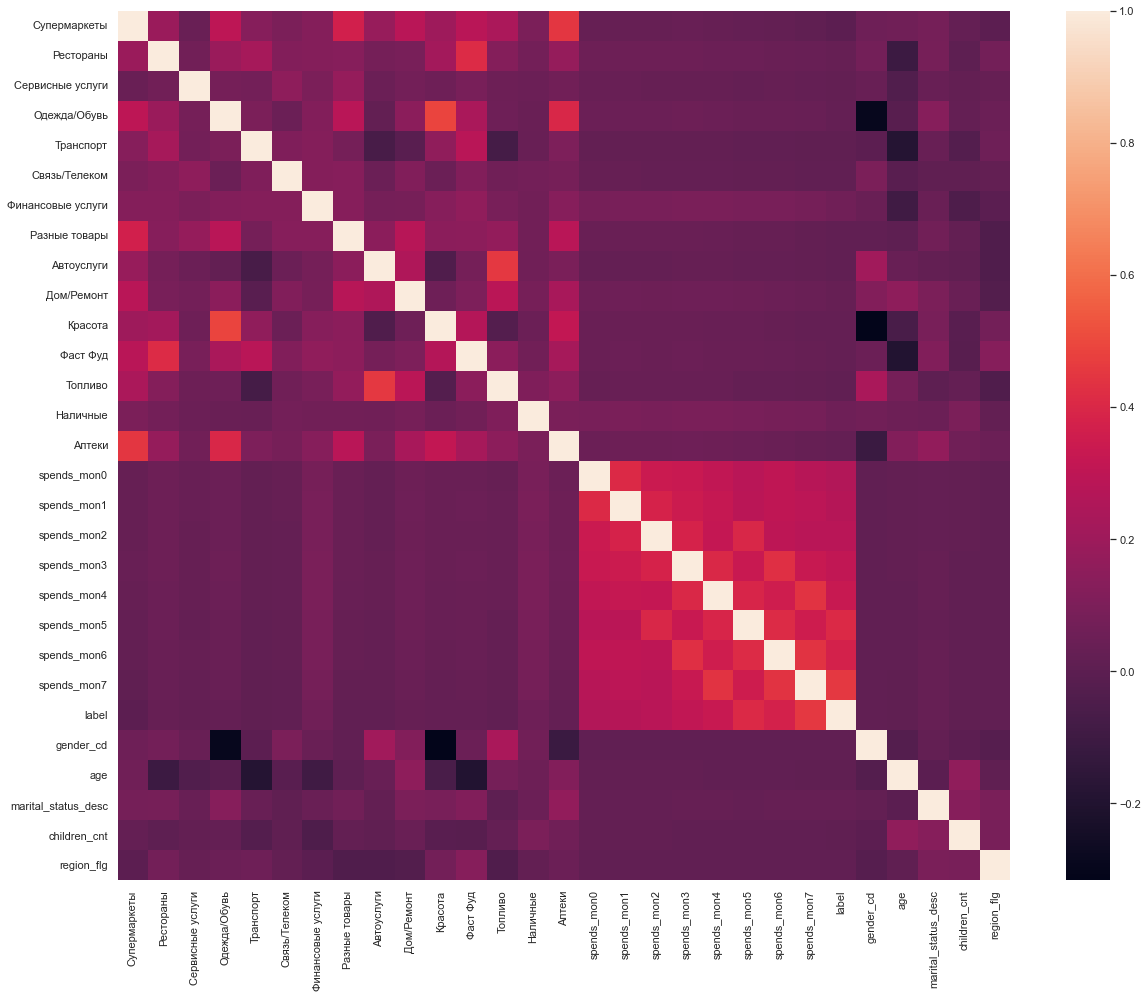

In [49]:
cols_to_cor = ['Супермаркеты', 'Рестораны',
       'Сервисные услуги', 'Одежда/Обувь', 'Транспорт', 'Связь/Телеком',
       'Финансовые услуги', 'Разные товары', 'Автоуслуги', 'Дом/Ремонт',
       'Красота', 'Фаст Фуд', 'Топливо', 'Наличные', 'Аптеки', 'spends_mon0',
       'spends_mon1', 'spends_mon2', 'spends_mon3', 'spends_mon4',
       'spends_mon5', 'spends_mon6', 'spends_mon7', 'label', 'gender_cd',
       'age', 'marital_status_desc', 'children_cnt', 'region_flg']

#corr = train_data.corr()
corr_2 = train_data[~((train_data.spends_mon0 == 0) & (train_data.spends_mon1 == 0) & (train_data.spends_mon2 == 0)
           & (train_data.spends_mon3 == 0) & (train_data.spends_mon4 == 0) & 
          (train_data.spends_mon5 == 0) & (train_data.spends_mon6 == 0) & 
                      (train_data.spends_mon7 == 0) & (train_data.label == 0))][cols_to_cor].corr()

# plot the heatmap
sns.set(rc={'figure.figsize':(20,16)})
sns.heatmap(corr_2, 
        xticklabels=corr_2.columns,
        yticklabels=corr_2.columns)

In [264]:
train = train[~((train.spends_mon0 == 0) & (train.spends_mon1 == 0) & (train.spends_mon2 == 0)
           & (train.spends_mon3 == 0) & (train.spends_mon4 == 0) & 
          (train.spends_mon5 == 0) & (train.spends_mon6 == 0) & (train.spends_mon7 == 0) & (train.label == 0))]
train.shape

(486592, 44)

In [8]:
tr_data = train.drop(['label'], axis=1)
tr_label = train['label']

ev_data = evals.drop(['label'], axis=1)
ev_label = evals['label']
tr_data = tr_data.reset_index(drop=True)
tr_label = tr_label.reset_index(drop=True)
ev_data = ev_data.reset_index(drop=True)
ev_label = ev_label.reset_index(drop=True)
tr_data.shape, tr_label.shape, ev_data.shape, ev_label.shape

((701730, 43), (701730,), (233910, 43), (233910,))

In [220]:
import optuna
import time
from lightgbm import LGBMRegressor, early_stopping, log_evaluation, plot_importance
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [13]:
def perc(y_pred, y_true):
    residual = abs((y_true - y_pred).astype("float"))
    lin = np.where((residual <= y_true * 0.2), 1, 0)

    return sum(lin)/len(y_true)

def objective(trial):
        """
        Function to optimize model params
        :param trial:(optuna instance) iteration
        :return:(float) metric of model iteration
        """

        param = {
            'n_jobs': -1,
            'objective': 'mae',
            'random_state': 42,
            'n_estimators': 150,
            'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
            'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
            'colsample_bytree': trial.suggest_categorical('colsample_bytree',
                                                          [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]),
            'subsample': trial.suggest_categorical('subsample', [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0]),
            'learning_rate': trial.suggest_float('learning_rate', 0.0001, 3),
            'max_depth': trial.suggest_categorical('max_depth', [-1, 13, 15, 17, 19, 21, 25, 28, 31, 35]),
            'num_leaves': trial.suggest_int('num_leaves', 2, 100),
            'min_child_samples': trial.suggest_int('min_child_samples', 10, 20000),
            'min_data_per_group': trial.suggest_int('min_data_per_group', 10, 20000)
        }
        model = LGBMRegressor(**param)
        st = time.time()
        model.fit(tr_data.values, tr_label.values, eval_set=[(ev_data, ev_label)],
                  callbacks=[early_stopping(60, verbose=0), log_evaluation(-1)])

        curr_preds = model.predict(ev_data)
        mask = ev_data[~((ev_data.spends_mon0 == 0) & (ev_data.spends_mon1 == 0) & (ev_data.spends_mon2 == 0)
           & (ev_data.spends_mon3 == 0) & (ev_data.spends_mon4 == 0) & 
          (ev_data.spends_mon5 == 0) & (ev_data.spends_mon6 == 0) & (ev_data.spends_mon7 == 0))].index
        
        masked_preds = curr_preds.copy()
        masked_preds[mask] = 0

        curr_mae_metr = mean_absolute_error(ev_label, curr_preds)        
        curr_mae_metr_masked = mean_absolute_error(ev_label, masked_preds)
        
        percc = perc(curr_preds, ev_label)
        percc_masked = perc(masked_preds, ev_label)

        print(f'MAE: {round(curr_mae_metr, 4)}')
        print(f'MAE masked: {round(curr_mae_metr_masked, 4)}')
        print(f'Accuraty +-20%: {percc}')
        print(f'Accuraty +-20% masked: {percc_masked}')
        print(f'Fit time: {time.strftime("%H:%M:%S", time.gmtime(time.time() - st))}\n')
        return percc#, curr_mae_metr
    

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=25)

[I 2022-02-28 13:36:19,520] A new study created in memory with name: no-name-436e733b-868f-4635-8041-1a5487236048
[I 2022-02-28 13:36:24,603] Trial 0 finished with value: 0.483946817151896 and parameters: {'reg_alpha': 0.028431854397782865, 'reg_lambda': 0.63424175165587, 'colsample_bytree': 0.8, 'subsample': 0.3, 'learning_rate': 1.8656366641949966, 'max_depth': -1, 'num_leaves': 24, 'min_child_samples': 6466, 'min_data_per_group': 14881}. Best is trial 0 with value: 0.483946817151896.


MAE: 3623.8873
MAE masked: 4479.4732
Accuraty +-20%: 0.483946817151896
Accuraty +-20% masked: 0.6273524004959172
Fit time: 00:00:05



[I 2022-02-28 13:36:35,230] Trial 1 finished with value: 0.3779316831259886 and parameters: {'reg_alpha': 1.2053010172587422, 'reg_lambda': 1.2324243411313394, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 1.6275865817953235, 'max_depth': 28, 'num_leaves': 76, 'min_child_samples': 5258, 'min_data_per_group': 11093}. Best is trial 0 with value: 0.483946817151896.


MAE: 3645.3608
MAE masked: 4479.4853
Accuraty +-20%: 0.3779316831259886
Accuraty +-20% masked: 0.6268051814800565
Fit time: 00:00:10



[I 2022-02-28 13:36:43,465] Trial 2 finished with value: 0.31622418879056047 and parameters: {'reg_alpha': 0.040388242581546045, 'reg_lambda': 0.6941653131354054, 'colsample_bytree': 0.2, 'subsample': 1.0, 'learning_rate': 0.9144069775478095, 'max_depth': -1, 'num_leaves': 89, 'min_child_samples': 6645, 'min_data_per_group': 10957}. Best is trial 0 with value: 0.483946817151896.


MAE: 3518.1853
MAE masked: 4493.1915
Accuraty +-20%: 0.31622418879056047
Accuraty +-20% masked: 0.5553332478303621
Fit time: 00:00:08



[I 2022-02-28 13:36:46,973] Trial 3 finished with value: 0.5644991663460305 and parameters: {'reg_alpha': 0.006953523002211875, 'reg_lambda': 0.035046372787517044, 'colsample_bytree': 0.5, 'subsample': 0.2, 'learning_rate': 2.036332380996926, 'max_depth': 31, 'num_leaves': 50, 'min_child_samples': 8691, 'min_data_per_group': 10037}. Best is trial 3 with value: 0.5644991663460305.


MAE: 4123.6412
MAE masked: 4479.4732
Accuraty +-20%: 0.5644991663460305
Accuraty +-20% masked: 0.6273524004959172
Fit time: 00:00:03



[I 2022-02-28 13:36:54,567] Trial 4 finished with value: 0.4675687230131247 and parameters: {'reg_alpha': 0.006240675066144544, 'reg_lambda': 0.006321538566644937, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 1.3867286055518009, 'max_depth': 31, 'num_leaves': 51, 'min_child_samples': 10098, 'min_data_per_group': 17336}. Best is trial 3 with value: 0.5644991663460305.


MAE: 3514.2797
MAE masked: 4479.4732
Accuraty +-20%: 0.4675687230131247
Accuraty +-20% masked: 0.6264503441494592
Fit time: 00:00:07



[I 2022-02-28 13:37:01,537] Trial 5 finished with value: 0.4252533025522637 and parameters: {'reg_alpha': 0.11025451900582563, 'reg_lambda': 0.013126346977193767, 'colsample_bytree': 0.4, 'subsample': 0.8, 'learning_rate': 1.6124385873319957, 'max_depth': -1, 'num_leaves': 36, 'min_child_samples': 9087, 'min_data_per_group': 15404}. Best is trial 3 with value: 0.5644991663460305.


MAE: 3586.5618
MAE masked: 4479.6175
Accuraty +-20%: 0.4252533025522637
Accuraty +-20% masked: 0.6245222521482622
Fit time: 00:00:06



[I 2022-02-28 13:37:03,143] Trial 6 finished with value: 0.5550681886195545 and parameters: {'reg_alpha': 0.019153954859439024, 'reg_lambda': 0.07413642117073563, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 2.0362482196359224, 'max_depth': 15, 'num_leaves': 4, 'min_child_samples': 18758, 'min_data_per_group': 14311}. Best is trial 3 with value: 0.5644991663460305.


MAE: 4110.4065
MAE masked: 4479.4732
Accuraty +-20%: 0.5550681886195545
Accuraty +-20% masked: 0.6273524004959172
Fit time: 00:00:01



[I 2022-02-28 13:37:09,688] Trial 7 finished with value: 0.4562224787311359 and parameters: {'reg_alpha': 0.012551080009792331, 'reg_lambda': 0.13479238400601057, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 1.9805223500465956, 'max_depth': -1, 'num_leaves': 85, 'min_child_samples': 5829, 'min_data_per_group': 4510}. Best is trial 3 with value: 0.5644991663460305.


MAE: 3972.5362
MAE masked: 4479.5364
Accuraty +-20%: 0.4562224787311359
Accuraty +-20% masked: 0.6271258176221624
Fit time: 00:00:06



[I 2022-02-28 13:37:12,803] Trial 8 finished with value: 0.5095635073318798 and parameters: {'reg_alpha': 0.002979278732991457, 'reg_lambda': 3.731082136177618, 'colsample_bytree': 0.1, 'subsample': 0.5, 'learning_rate': 2.6230747096022267, 'max_depth': 28, 'num_leaves': 98, 'min_child_samples': 1665, 'min_data_per_group': 4196}. Best is trial 3 with value: 0.5644991663460305.


MAE: 4430.344
MAE masked: 4491.4128
Accuraty +-20%: 0.5095635073318798
Accuraty +-20% masked: 0.6043221751955881
Fit time: 00:00:03



[I 2022-02-28 13:37:22,575] Trial 9 finished with value: 0.47455859091103414 and parameters: {'reg_alpha': 3.6822763808677705, 'reg_lambda': 0.009859987912656637, 'colsample_bytree': 0.5, 'subsample': 0.3, 'learning_rate': 1.2299489973244264, 'max_depth': -1, 'num_leaves': 72, 'min_child_samples': 6717, 'min_data_per_group': 14986}. Best is trial 3 with value: 0.5644991663460305.


MAE: 3511.2258
MAE masked: 4479.5785
Accuraty +-20%: 0.47455859091103414
Accuraty +-20% masked: 0.6264631695951435
Fit time: 00:00:09



[I 2022-02-28 13:37:29,257] Trial 10 finished with value: 0.46181009790090205 and parameters: {'reg_alpha': 0.0010668531212590878, 'reg_lambda': 0.0011886012654536665, 'colsample_bytree': 0.7, 'subsample': 0.2, 'learning_rate': 0.1746208237730238, 'max_depth': 21, 'num_leaves': 58, 'min_child_samples': 14488, 'min_data_per_group': 7529}. Best is trial 3 with value: 0.5644991663460305.


MAE: 3559.2155
MAE masked: 4479.6281
Accuraty +-20%: 0.46181009790090205
Accuraty +-20% masked: 0.6264631695951435
Fit time: 00:00:06



[I 2022-02-28 13:37:31,004] Trial 11 finished with value: 0.5591894318327562 and parameters: {'reg_alpha': 0.18576538204166737, 'reg_lambda': 0.06963110165300826, 'colsample_bytree': 0.3, 'subsample': 0.7, 'learning_rate': 2.615563994917215, 'max_depth': 15, 'num_leaves': 4, 'min_child_samples': 19899, 'min_data_per_group': 19410}. Best is trial 3 with value: 0.5644991663460305.


MAE: 4450.9221
MAE masked: 4479.4732
Accuraty +-20%: 0.5591894318327562
Accuraty +-20% masked: 0.6273524004959172
Fit time: 00:00:01



[I 2022-02-28 13:37:32,707] Trial 12 finished with value: 0.5572527895344364 and parameters: {'reg_alpha': 0.24389089456546081, 'reg_lambda': 0.07149693614828193, 'colsample_bytree': 0.3, 'subsample': 0.7, 'learning_rate': 2.781450531570222, 'max_depth': 13, 'num_leaves': 8, 'min_child_samples': 19755, 'min_data_per_group': 19796}. Best is trial 3 with value: 0.5644991663460305.


MAE: 4503.2981
MAE masked: 4479.4732
Accuraty +-20%: 0.5572527895344364
Accuraty +-20% masked: 0.6273524004959172
Fit time: 00:00:01



[I 2022-02-28 13:37:35,237] Trial 13 finished with value: 0.572143131973836 and parameters: {'reg_alpha': 0.3584613487794544, 'reg_lambda': 0.03149543563930079, 'colsample_bytree': 0.3, 'subsample': 0.7, 'learning_rate': 2.4004208781276115, 'max_depth': 31, 'num_leaves': 28, 'min_child_samples': 14534, 'min_data_per_group': 332}. Best is trial 13 with value: 0.572143131973836.


MAE: 4330.5986
MAE masked: 4479.4732
Accuraty +-20%: 0.572143131973836
Accuraty +-20% masked: 0.6273524004959172
Fit time: 00:00:02



[I 2022-02-28 13:37:37,640] Trial 14 finished with value: 0.5647770510025223 and parameters: {'reg_alpha': 0.6354132127367318, 'reg_lambda': 0.02099828883560382, 'colsample_bytree': 1.0, 'subsample': 0.2, 'learning_rate': 2.2606163374612422, 'max_depth': 31, 'num_leaves': 35, 'min_child_samples': 13914, 'min_data_per_group': 984}. Best is trial 13 with value: 0.572143131973836.


MAE: 4291.8395
MAE masked: 4479.4732
Accuraty +-20%: 0.5647770510025223
Accuraty +-20% masked: 0.6273524004959172
Fit time: 00:00:02



[I 2022-02-28 13:37:40,182] Trial 15 finished with value: 0.5641742550553632 and parameters: {'reg_alpha': 0.9614551963699646, 'reg_lambda': 0.001915741852701842, 'colsample_bytree': 1.0, 'subsample': 0.4, 'learning_rate': 2.433374154459665, 'max_depth': 31, 'num_leaves': 27, 'min_child_samples': 14627, 'min_data_per_group': 401}. Best is trial 13 with value: 0.572143131973836.


MAE: 4343.9562
MAE masked: 4479.4732
Accuraty +-20%: 0.5641742550553632
Accuraty +-20% masked: 0.6273524004959172
Fit time: 00:00:02



[I 2022-02-28 13:37:42,628] Trial 16 finished with value: 0.5626394767218161 and parameters: {'reg_alpha': 0.5994528620006865, 'reg_lambda': 0.0039028066170714647, 'colsample_bytree': 1.0, 'subsample': 0.1, 'learning_rate': 2.9867385639839115, 'max_depth': 35, 'num_leaves': 36, 'min_child_samples': 14141, 'min_data_per_group': 263}. Best is trial 13 with value: 0.572143131973836.


MAE: 4549.7938
MAE masked: 4479.4732
Accuraty +-20%: 0.5626394767218161
Accuraty +-20% masked: 0.6273524004959172
Fit time: 00:00:02



[I 2022-02-28 13:37:44,905] Trial 17 finished with value: 0.5809071865247317 and parameters: {'reg_alpha': 7.645316802896626, 'reg_lambda': 0.02201008665068622, 'colsample_bytree': 0.3, 'subsample': 0.2, 'learning_rate': 2.342247158285194, 'max_depth': 19, 'num_leaves': 21, 'min_child_samples': 11911, 'min_data_per_group': 3081}. Best is trial 17 with value: 0.5809071865247317.


MAE: 4365.6259
MAE masked: 4479.4732
Accuraty +-20%: 0.5809071865247317
Accuraty +-20% masked: 0.6273524004959172
Fit time: 00:00:02



[I 2022-02-28 13:37:50,214] Trial 18 finished with value: 0.4502671967850883 and parameters: {'reg_alpha': 3.645057706916604, 'reg_lambda': 0.24188848053901163, 'colsample_bytree': 0.3, 'subsample': 0.7, 'learning_rate': 0.7277106141911804, 'max_depth': 19, 'num_leaves': 17, 'min_child_samples': 16803, 'min_data_per_group': 3995}. Best is trial 17 with value: 0.5809071865247317.


MAE: 3591.6735
MAE masked: 4479.4732
Accuraty +-20%: 0.4502671967850883
Accuraty +-20% masked: 0.6273524004959172
Fit time: 00:00:05



[I 2022-02-28 13:37:52,579] Trial 19 finished with value: 0.5811636954384165 and parameters: {'reg_alpha': 7.18351706674256, 'reg_lambda': 0.02824828623468512, 'colsample_bytree': 0.3, 'subsample': 0.4, 'learning_rate': 2.285027667255399, 'max_depth': 17, 'num_leaves': 19, 'min_child_samples': 11646, 'min_data_per_group': 6787}. Best is trial 19 with value: 0.5811636954384165.


MAE: 4349.5726
MAE masked: 4479.4732
Accuraty +-20%: 0.5811636954384165
Accuraty +-20% masked: 0.6273524004959172
Fit time: 00:00:02



[I 2022-02-28 13:37:54,766] Trial 20 finished with value: 0.5808943610790475 and parameters: {'reg_alpha': 8.169512651479604, 'reg_lambda': 0.003122019591494148, 'colsample_bytree': 0.3, 'subsample': 0.4, 'learning_rate': 2.258184160705377, 'max_depth': 17, 'num_leaves': 16, 'min_child_samples': 11439, 'min_data_per_group': 7365}. Best is trial 19 with value: 0.5811636954384165.


MAE: 4346.7174
MAE masked: 4479.4732
Accuraty +-20%: 0.5808943610790475
Accuraty +-20% masked: 0.6273524004959172
Fit time: 00:00:02



[I 2022-02-28 13:37:56,960] Trial 21 finished with value: 0.5808302338506263 and parameters: {'reg_alpha': 7.103636216310399, 'reg_lambda': 0.003052125216465854, 'colsample_bytree': 0.3, 'subsample': 0.4, 'learning_rate': 2.2631164751780073, 'max_depth': 17, 'num_leaves': 15, 'min_child_samples': 10953, 'min_data_per_group': 7368}. Best is trial 19 with value: 0.5811636954384165.


MAE: 4347.9961
MAE masked: 4479.4732
Accuraty +-20%: 0.5808302338506263
Accuraty +-20% masked: 0.6273524004959172
Fit time: 00:00:02



[I 2022-02-28 13:38:02,044] Trial 22 finished with value: 0.31809242871189775 and parameters: {'reg_alpha': 9.85539825498306, 'reg_lambda': 0.006425636985941228, 'colsample_bytree': 0.3, 'subsample': 0.4, 'learning_rate': 1.7382963171393606, 'max_depth': 17, 'num_leaves': 16, 'min_child_samples': 11796, 'min_data_per_group': 7888}. Best is trial 19 with value: 0.5811636954384165.


MAE: 3663.603
MAE masked: 4480.4983
Accuraty +-20%: 0.31809242871189775
Accuraty +-20% masked: 0.6198366893249541
Fit time: 00:00:05



[I 2022-02-28 13:38:05,078] Trial 23 finished with value: 0.5752041383438075 and parameters: {'reg_alpha': 2.3422971894189324, 'reg_lambda': 0.020554251582992483, 'colsample_bytree': 0.3, 'subsample': 0.4, 'learning_rate': 2.8766682300031206, 'max_depth': 25, 'num_leaves': 46, 'min_child_samples': 11822, 'min_data_per_group': 5955}. Best is trial 19 with value: 0.5811636954384165.


MAE: 4620.3249
MAE masked: 4479.4732
Accuraty +-20%: 0.5752041383438075
Accuraty +-20% masked: 0.6273524004959172
Fit time: 00:00:03



[I 2022-02-28 13:38:07,153] Trial 24 finished with value: 0.5866615364883929 and parameters: {'reg_alpha': 1.9228332268203039, 'reg_lambda': 0.0012926114872329744, 'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 2.224014384782215, 'max_depth': 17, 'num_leaves': 13, 'min_child_samples': 13048, 'min_data_per_group': 2732}. Best is trial 24 with value: 0.5866615364883929.


MAE: 4334.1799
MAE masked: 4479.4732
Accuraty +-20%: 0.5866615364883929
Accuraty +-20% masked: 0.6273524004959172
Fit time: 00:00:02



In [385]:
def perc(y_pred, y_true):
    residual = abs((y_true - y_pred).astype("float"))
    lin = np.where((residual <= y_true * 0.2), 1, 0)

    return sum(lin)/len(y_true)
from sklearn.ensemble import RandomForestRegressor

def objective(trial):
        """
        Function to optimize model params
        :param trial:(optuna instance) iteration
        :return:(float) metric of model iteration
        """

        param = {
            'n_jobs': -1,
            'criterion': 'absolute_error',
            'random_state': 42,
            'n_estimators': trial.suggest_int('n_estimators', 1, 2),
            'max_depth': trial.suggest_categorical('max_depth', [-1, 13, 15, 17, 19, 21, 25, 28, 31, 35]),
            'min_samples_split': trial.suggest_int('min_child_samples', 2, 20000),
            'min_samples_leaf': trial.suggest_int('min_data_per_group', 1, 20000)
        }
        model = RandomForestRegressor(**param)
        st = time.time()
        model.fit(tr_data.values, tr_label.values)

        curr_preds = model.predict(ev_data)
        mask = ev_data[~((ev_data.spends_mon0 == 0) & (ev_data.spends_mon1 == 0) & (ev_data.spends_mon2 == 0)
           & (ev_data.spends_mon3 == 0) & (ev_data.spends_mon4 == 0) & 
          (ev_data.spends_mon5 == 0) & (ev_data.spends_mon6 == 0) & (ev_data.spends_mon7 == 0))].index
        
        masked_preds = curr_preds.copy()
        masked_preds[mask] = 0

        curr_mae_metr = mean_absolute_error(ev_label, curr_preds)        
        curr_mae_metr_masked = mean_absolute_error(ev_label, masked_preds)
        
        percc = perc(curr_preds, ev_label)
        percc_masked = perc10(masked_preds, ev_label)

        print(f'MAE: {round(curr_mae_metr, 4)}')
        print(f'MAE masked: {round(curr_mae_metr_masked, 4)}')
        print(f'Accuraty +-20%: {percc}')
        print(f'Accuraty +-20% masked: {percc_masked}')
        print(f'Fit time: {time.strftime("%H:%M:%S", time.gmtime(time.time() - st))}\n')
        return curr_mae_metr
    

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=2)

[I 2022-02-28 13:05:43,222] A new study created in memory with name: no-name-efec8143-0145-495c-b2e1-5f592bbede31


KeyboardInterrupt: 

In [394]:
def perc(y_pred, y_true):
    residual = abs((y_true - y_pred).astype("float"))
    lin = np.where((residual <= y_true * 0.2), 1, 0)

    return sum(lin)/len(y_true)
from sklearn.linear_model import LinearRegression

def objective(trial):
        """
        Function to optimize model params
        :param trial:(optuna instance) iteration
        :return:(float) metric of model iteration
        """

        model = LinearRegression()
        st = time.time()
        model.fit(tr_data.values, tr_label.values)

        curr_preds = model.predict(ev_data)
        mask = ev_data[~((ev_data.spends_mon0 == 0) & (ev_data.spends_mon1 == 0) & (ev_data.spends_mon2 == 0)
           & (ev_data.spends_mon3 == 0) & (ev_data.spends_mon4 == 0) & 
          (ev_data.spends_mon5 == 0) & (ev_data.spends_mon6 == 0) & (ev_data.spends_mon7 == 0))].index
        
        masked_preds = curr_preds.copy()
        masked_preds[mask] = 0

        curr_mae_metr = mean_absolute_error(ev_label, curr_preds)        
        curr_mae_metr_masked = mean_absolute_error(ev_label, masked_preds)
        
        percc = perc(curr_preds, ev_label)
        percc_masked = perc10(masked_preds, ev_label)

        print(f'MAE: {round(curr_mae_metr, 4)}')
        print(f'MAE masked: {round(curr_mae_metr_masked, 4)}')
        print(f'Accuraty +-20%: {percc}')
        print(f'Accuraty +-20% masked: {percc_masked}')
        print(f'Fit time: {time.strftime("%H:%M:%S", time.gmtime(time.time() - st))}\n')
        return curr_mae_metr
    

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1)

[I 2022-02-28 13:14:42,984] A new study created in memory with name: no-name-e386da60-3a33-4403-9d7b-1ad76730b187
/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
[I 2022-02-28 13:14:50,145] Trial 0 finished with value: 4597.968338686354 and parameters: {}. Best is trial 0 with value: 4597.968338686354.


MAE: 4597.9683
MAE masked: 4875.9568
Accuraty +-20%: 0.04912573211919114
Accuraty +-20% masked: 0.35060493352143984
Fit time: 00:00:07



/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
[I 2022-02-28 13:14:55,669] Trial 1 finished with value: 4597.968338686354 and parameters: {}. Best is trial 0 with value: 4597.968338686354.


MAE: 4597.9683
MAE masked: 4875.9568
Accuraty +-20%: 0.04912573211919114
Accuraty +-20% masked: 0.35060493352143984
Fit time: 00:00:05



In [14]:
model_params = study.best_trial.params
print('Best params:')
print(model_params, '\n')

Best params:
{'reg_alpha': 1.9228332268203039, 'reg_lambda': 0.0012926114872329744, 'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 2.224014384782215, 'max_depth': 17, 'num_leaves': 13, 'min_child_samples': 13048, 'min_data_per_group': 2732} 



In [16]:
opt_model = LGBMRegressor(n_jobs=-1, objective='mae', random_state=42, n_estimators=400, **model_params)
opt_model.fit(tr_data, tr_label, eval_set=[(ev_data, ev_label)],
                  callbacks=[early_stopping(80, verbose=0), log_evaluation(-1)])

LGBMRegressor(colsample_bytree=0.7, learning_rate=2.224014384782215,
              max_depth=17, min_child_samples=13048, min_data_per_group=2732,
              n_estimators=400, num_leaves=13, objective='mae', random_state=42,
              reg_alpha=1.9228332268203039, reg_lambda=0.0012926114872329744,
              subsample=0.4)

In [19]:
curr_preds = opt_model.predict(ev_data)
mask = ev_data[~((ev_data.spends_mon0 == 0) & (ev_data.spends_mon1 == 0) & (ev_data.spends_mon2 == 0)
   & (ev_data.spends_mon3 == 0) & (ev_data.spends_mon4 == 0) & 
  (ev_data.spends_mon5 == 0) & (ev_data.spends_mon6 == 0) & (ev_data.spends_mon7 == 0))].index

masked_preds = curr_preds.copy()
masked_preds[mask] = 0

curr_mae_metr = mean_absolute_error(ev_label, curr_preds)

curr_mae_metr_masked = mean_absolute_error(ev_label, masked_preds)

percc = perc(curr_preds, ev_label)
percc_masked = perc(masked_preds, ev_label)

print(f'MAE: {round(curr_mae_metr, 4)}')
print(f'MAE masked: {round(curr_mae_metr_masked, 4)}')
print(f'Accuraty +-20%: {percc}')
print(f'Accuraty +-20% masked: {percc_masked}')


MAE: 4334.1799
MAE masked: 4479.4732
Accuraty +-20%: 0.5866615364883929
Accuraty +-20% masked: 0.6273524004959172


In [24]:
mm = ev_label[ev_label < ev_label.quantile(0.95)].index
print(ev_label.quantile(0.95))

16020.426999999958


In [21]:
len(mm), len(ev_label)

(222214, 233910)

In [22]:
curr_mae_metr = mean_absolute_error(ev_label[mm], curr_preds[mm])

curr_mae_metr_masked = mean_absolute_error(ev_label[mm], masked_preds[mm])

print(f'MAE: {round(curr_mae_metr, 4)}')
print(f'MAE masked: {round(curr_mae_metr_masked, 4)}')
percc = perc(masked_preds[mm], ev_label[mm])
print(f'Accuracy 90-100%: {round(percc, 5)}')

MAE: 1323.2732
MAE masked: 1094.7247
Accuracy 90-100%: 0.66037


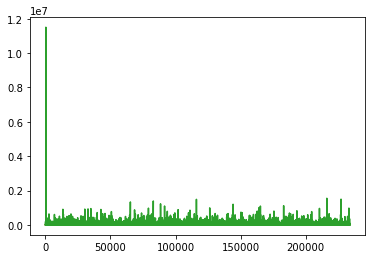

In [23]:
plt.plot(np.arange(0, len(masked_preds)), masked_preds)
plt.plot(np.arange(0, len(masked_preds)), curr_preds)
plt.plot(np.arange(0, len(masked_preds)), ev_label)

In [26]:
story_text = pd.read_csv(path_data + 'data_story_texts.csv')
print(story_text.shape)
story_text.head()

(1631, 3)


,story_id,name,story_text
0,794,Профессия: свадебный организатор,"["""",""Как стать свадебным организатором"",""Это Л..."
1,821,Бизнес: магазин электроники,"["""",""Как открыть интернет-магазин электроники""..."
2,824,Как у них: Сингапур,"["""",""Жизнь в Сингапуре"",""Это Славина. Вместе с..."
3,839,Студии йоги,"["""",""Студии йоги"",""7 московских студий, где мо..."
4,848,Как получать больше кэшбэка,"["""",""Как получать больше кэшбэка"",""Подключите ..."


In [27]:
story_logs = pd.read_csv(path_data + 'data_story_logs.csv')
print(story_logs.shape)
story_logs.head()

(13820, 5)


,party_rk,date_time,story_id,category,event
0,64266,2019-12-01 13:05:31,3840,39,like
1,55721,2019-12-01 13:18:08,3857,39,like
2,27563,2019-12-01 13:25:40,3174,78,like
3,61223,2019-12-01 13:25:20,3857,39,like
4,61223,2019-12-01 13:29:05,3765,73,like


In [28]:
story = story_logs.merge(story_text, how='inner', on='story_id')
story

,party_rk,date_time,story_id,category,event,name,story_text
0,64266,2019-12-01 13:05:31,3840,39,like,Новый год с Тинькофф,"["""",""Адвент-календарь Тинькофф уже запущен,fon..."
1,48382,2019-12-10 12:06:47,3840,39,like,Новый год с Тинькофф,"["""",""Адвент-календарь Тинькофф уже запущен,fon..."
2,60388,2019-12-01 13:36:04,3840,39,favorite,Новый год с Тинькофф,"["""",""Адвент-календарь Тинькофф уже запущен,fon..."
3,46954,2019-12-01 14:08:50,3840,39,like,Новый год с Тинькофф,"["""",""Адвент-календарь Тинькофф уже запущен,fon..."
4,20059,2019-12-01 14:24:25,3840,39,like,Новый год с Тинькофф,"["""",""Адвент-календарь Тинькофф уже запущен,fon..."
...,...,...,...,...,...,...,...
13722,9607,2019-01-08 22:13:16,1140,81,like,Бизнес: керамика,"["""",""Как заработать на производстве керамики"",..."
13723,77860,2019-06-18 10:40:14,2707,7,54],NaN,"["""",""Дикая мята — 2019"",""Дарим билеты на три д..."
13724,54800,2019-01-26 23:01:40,1748,81,like,4 каско на выбор,"["""",""Полис каско"",""Теперь не только от Тинькоф..."
13725,37232,2019-06-26 21:52:49,2795,49,like,Спектакли июля,"["""",""Спектакли июля"",""На что успеть сходить пе..."


In [30]:
len(list(set(story.party_rk)))

3914

In [33]:
story = story[story.event.isin(['like', 'dislike', 'favorite'])]

In [38]:
story.date_time[0].split('-')[0] + '-' + story.date_time[0].split('-')[1]

'2019-12'

In [39]:
def story_date(x):
    return x.split('-')[0] + '-' + x.split('-')[1]
story['date_time'] = story['date_time'].apply(story_date)
story

/var/folders/c6/xll9k3b14x336rm4ny60zzmr0000gn/T/ipykernel_60319/1204682591.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  story['date_time'] = story['date_time'].apply(story_date)


,party_rk,date_time,story_id,category,event,name,story_text
0,64266,2019-12,3840,39,like,Новый год с Тинькофф,"["""",""Адвент-календарь Тинькофф уже запущен,fon..."
1,48382,2019-12,3840,39,like,Новый год с Тинькофф,"["""",""Адвент-календарь Тинькофф уже запущен,fon..."
2,60388,2019-12,3840,39,favorite,Новый год с Тинькофф,"["""",""Адвент-календарь Тинькофф уже запущен,fon..."
3,46954,2019-12,3840,39,like,Новый год с Тинькофф,"["""",""Адвент-календарь Тинькофф уже запущен,fon..."
4,20059,2019-12,3840,39,like,Новый год с Тинькофф,"["""",""Адвент-календарь Тинькофф уже запущен,fon..."
...,...,...,...,...,...,...,...
13721,3645,2019-11,3785,49,like,Музеи Краснодара,"["""",""Музеи Краснодара,font_name:Montserrat"",""К..."
13722,9607,2019-01,1140,81,like,Бизнес: керамика,"["""",""Как заработать на производстве керамики"",..."
13724,54800,2019-01,1748,81,like,4 каско на выбор,"["""",""Полис каско"",""Теперь не только от Тинькоф..."
13725,37232,2019-06,2795,49,like,Спектакли июля,"["""",""Спектакли июля"",""На что успеть сходить пе..."


In [151]:
unique_texts = list(set(story.story_text.values))



In [159]:
import string
from natasha import Segmenter, MorphVocab, Doc
segmenter = Segmenter()
morph_vocab = MorphVocab()


from dostoevsky.tokenization import RegexTokenizer
from dostoevsky.models import FastTextSocialNetworkModel

tokenizer = RegexTokenizer()
model = FastTextSocialNetworkModel(tokenizer=tokenizer)

def sentiment(x, model, Doc, segmenter, morph_vocab, tokenizer):
    text = x.replace('\xa0', '')[5:-2]
    doc = Doc(text)
    doc.segment(segmenter)
    doc.tag_morph(morph_tagger)
    em = ''
    for d in doc.tokens:
        if d.pos != 'PUNCT':
            em = em + ' ' + d.text
    em = em[1:]
    preds = model.predict([em], k=5)
    #print(em, '\n')
    #print(preds)
    return preds

In [150]:
pr = sentiment(unique_texts[1200], model, Doc, segmenter, morph_vocab, tokenizer)
print(pr)
out_ar = [pr[0]['neutral'], pr[0]['positive'], pr[0]['negative']]
out_ar

Перевод на карту это еще не доход В СМИ пугают чтовсе переводы накарту— этодоход Неволнуйтесь вам ненужно платить НДФЛ совсех поступлений накарту Если вам дарят деньги или подарок от родственника забудьте про налоги Когда вам возвращают долг это тоже не доход Еще не платят налоги спенсии стипендии иблаготворительной помощи Даже урепетитора есть налоговые каникулы в 2018 году Мы выяснили какие доходы облагаются налогом Узнать 

[{'neutral': 0.7663036584854126, 'negative': 0.3140605390071869, 'skip': 0.09010298550128937, 'positive': 0.029322227463126183, 'speech': 0.004915405530482531}]


[0.7663036584854126, 0.029322227463126183, 0.3140605390071869]

In [154]:
story.head()

,party_rk,date_time,story_id,category,event,name,story_text
0,64266,2019-12,3840,39,like,Новый год с Тинькофф,"["""",""Адвент-календарь Тинькофф уже запущен,fon..."
1,48382,2019-12,3840,39,like,Новый год с Тинькофф,"["""",""Адвент-календарь Тинькофф уже запущен,fon..."
2,60388,2019-12,3840,39,favorite,Новый год с Тинькофф,"["""",""Адвент-календарь Тинькофф уже запущен,fon..."
3,46954,2019-12,3840,39,like,Новый год с Тинькофф,"["""",""Адвент-календарь Тинькофф уже запущен,fon..."
4,20059,2019-12,3840,39,like,Новый год с Тинькофф,"["""",""Адвент-календарь Тинькофф уже запущен,fon..."


In [157]:
story.iloc[:,6].value_counts()

["","{{w_period}}","Расходы за неделю","{{w_sum}} ₽","На прошлой неделе: {{w_sum2}} ₽","На что вы тратили деньги","{{w_period}}","Регулярные траты","{{w_reg_cat1}}","{{w_reg_cat1_sum}} ₽","{{w_reg_cat1_sum_dif}} ₽","Больше всего: {{w_reg_cat1_sum_max}} ₽)","!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!","{{w_reg_cat2}}","{{w_reg_cat2_sum}} ₽","{{w_reg_cat2_sum_dif}} ₽","Больше всего: {{w_reg_cat2_sum_max}} ₽)","!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!","{{w_reg_cat3}}","{{w_reg_cat3_sum}} ₽","{{w_reg_cat3_sum_dif}} ₽","Больше всего: {{w_reg_cat3_sum_max}} ₽)","!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [162]:
neu = []
pos = []
neg = []
for item in story.story_text.values:
    pr = sentiment(item, model, Doc, segmenter, morph_vocab, tokenizer)    
    out_ar = [pr[0]['neutral'], pr[0]['positive'], pr[0]['negative']]
    neu.append(out_ar[0])
    pos.append(out_ar[1])
    neg.append(out_ar[2])
    clear_output(wait=True)
    print(f'Done {len(neu)} from {story.shape[0]}')

DOne 11687 from 11687


In [163]:
story['neutral'] = neu
story['positive'] = pos
story['negative'] = neg
story.head()

/var/folders/c6/xll9k3b14x336rm4ny60zzmr0000gn/T/ipykernel_60319/3886176760.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  story['neutral'] = neu
/var/folders/c6/xll9k3b14x336rm4ny60zzmr0000gn/T/ipykernel_60319/3886176760.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  story['positive'] = pos
/var/folders/c6/xll9k3b14x336rm4ny60zzmr0000gn/T/ipykernel_60319/3886176760.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

,party_rk,date_time,story_id,category,event,name,story_text,neutral,positive,negative
0,64266,2019-12,3840,39,like,Новый год с Тинькофф,"["""",""Адвент-календарь Тинькофф уже запущен,fon...",0.835494,0.044691,0.173298
1,48382,2019-12,3840,39,like,Новый год с Тинькофф,"["""",""Адвент-календарь Тинькофф уже запущен,fon...",0.835494,0.044691,0.173298
2,60388,2019-12,3840,39,favorite,Новый год с Тинькофф,"["""",""Адвент-календарь Тинькофф уже запущен,fon...",0.835494,0.044691,0.173298
3,46954,2019-12,3840,39,like,Новый год с Тинькофф,"["""",""Адвент-календарь Тинькофф уже запущен,fon...",0.835494,0.044691,0.173298
4,20059,2019-12,3840,39,like,Новый год с Тинькофф,"["""",""Адвент-календарь Тинькофф уже запущен,fon...",0.835494,0.044691,0.173298


In [167]:
story = pd.get_dummies(story, columns=['event'], prefix='event')
story.head()

,party_rk,date_time,story_id,category,name,story_text,neutral,positive,negative,event_dislike,event_favorite,event_like
0,64266,2019-12,3840,39,Новый год с Тинькофф,"["""",""Адвент-календарь Тинькофф уже запущен,fon...",0.835494,0.044691,0.173298,0,0,1
1,48382,2019-12,3840,39,Новый год с Тинькофф,"["""",""Адвент-календарь Тинькофф уже запущен,fon...",0.835494,0.044691,0.173298,0,0,1
2,60388,2019-12,3840,39,Новый год с Тинькофф,"["""",""Адвент-календарь Тинькофф уже запущен,fon...",0.835494,0.044691,0.173298,0,1,0
3,46954,2019-12,3840,39,Новый год с Тинькофф,"["""",""Адвент-календарь Тинькофф уже запущен,fon...",0.835494,0.044691,0.173298,0,0,1
4,20059,2019-12,3840,39,Новый год с Тинькофф,"["""",""Адвент-календарь Тинькофф уже запущен,fon...",0.835494,0.044691,0.173298,0,0,1


In [168]:
train_data.head()

,party_rk,start,end,Супермаркеты,Рестораны,Сервисные услуги,Одежда/Обувь,Транспорт,Связь/Телеком,Финансовые услуги,...,cur_cat_Одежда/Обувь,cur_cat_Разные товары,cur_cat_Рестораны,cur_cat_Связь/Телеком,cur_cat_Сервисные услуги,cur_cat_Супермаркеты,cur_cat_Топливо,cur_cat_Транспорт,cur_cat_Фаст Фуд,cur_cat_Финансовые услуги
0,65536,2019-01,2019-09,138,5,0,7,16,6,1,...,0,0,0,0,0,1,0,0,0,0
1,65536,2019-01,2019-09,138,5,0,7,16,6,1,...,0,0,1,0,0,0,0,0,0,0
2,65536,2019-01,2019-09,138,5,0,7,16,6,1,...,0,0,0,0,1,0,0,0,0,0
3,65536,2019-01,2019-09,138,5,0,7,16,6,1,...,1,0,0,0,0,0,0,0,0,0
4,65536,2019-01,2019-09,138,5,0,7,16,6,1,...,0,0,0,0,0,0,0,1,0,0


In [174]:
story_to_merge = ['party_rk', 'date_time', 'category', 'neutral', 'positive', 'negative', 
                  'event_dislike', 'event_favorite', 'event_like']

In [178]:
len(list(set(train_data.party_rk.values))), len(list(set(story.party_rk.values)))

(15594, 3235)

In [180]:
train_data.shape, story.shape

((935640, 47), (11687, 12))

In [187]:
story = story.drop_duplicates(keep='last')

In [194]:
story[story.party_rk == 64266]

,party_rk,date_time,story_id,category,name,story_text,neutral,positive,negative,event_dislike,event_favorite,event_like
0,64266,2019-12,3840,39,Новый год с Тинькофф,"["""",""Адвент-календарь Тинькофф уже запущен,fon...",0.835494,0.044691,0.173298,0,0,1


In [206]:
df_text = train_data.merge(story[story_to_merge], how='inner', on='party_rk')
df_text = df_text.drop_duplicates(keep='last')
df_text

,party_rk,start,end,Супермаркеты,Рестораны,Сервисные услуги,Одежда/Обувь,Транспорт,Связь/Телеком,Финансовые услуги,...,cur_cat_Фаст Фуд,cur_cat_Финансовые услуги,date_time,category,neutral,positive,negative,event_dislike,event_favorite,event_like
0,32775,2019-01,2019-09,50,2,0,2,17,3,1,...,0,0,2019-09,43,0.453272,0.129413,0.212079,0,1,0
1,32775,2019-01,2019-09,50,2,0,2,17,3,1,...,0,0,2019-09,43,0.453272,0.129413,0.212079,0,1,0
2,32775,2019-01,2019-09,50,2,0,2,17,3,1,...,0,0,2019-09,43,0.453272,0.129413,0.212079,0,1,0
3,32775,2019-01,2019-09,50,2,0,2,17,3,1,...,0,0,2019-09,43,0.453272,0.129413,0.212079,0,1,0
4,32775,2019-01,2019-09,50,2,0,2,17,3,1,...,0,0,2019-09,43,0.453272,0.129413,0.212079,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
683455,32762,2019-04,2019-12,20,0,0,0,0,0,14,...,0,0,2019-12,81,0.831153,0.136618,0.100889,1,0,0
683456,32762,2019-04,2019-12,20,0,0,0,0,0,14,...,0,0,2019-12,81,0.831153,0.136618,0.100889,0,0,1
683457,32762,2019-04,2019-12,20,0,0,0,0,0,14,...,0,0,2019-12,81,0.831153,0.136618,0.100889,1,0,0
683458,32762,2019-04,2019-12,20,0,0,0,0,0,14,...,0,0,2019-12,81,0.831153,0.136618,0.100889,0,0,1


In [208]:
df_text.to_csv(path_data + 'df_text.csv', index=False)

In [211]:
columns_to_train = ['Супермаркеты', 'Рестораны',
       'Сервисные услуги', 'Одежда/Обувь', 'Транспорт', 'Связь/Телеком',
       'Финансовые услуги', 'Разные товары', 'Автоуслуги', 'Дом/Ремонт',
       'Красота', 'Фаст Фуд', 'Топливо', 'Наличные', 'Аптеки', 'spends_mon0',
       'spends_mon1', 'spends_mon2', 'spends_mon3', 'spends_mon4',
       'spends_mon5', 'spends_mon6', 'spends_mon7', 'label', 'gender_cd',
       'age', 'marital_status_desc', 'children_cnt', 'region_flg',
       'cur_cat_Автоуслуги', 'cur_cat_Аптеки', 'cur_cat_Дом/Ремонт',
       'cur_cat_Красота', 'cur_cat_Наличные', 'cur_cat_Одежда/Обувь',
       'cur_cat_Разные товары', 'cur_cat_Рестораны', 'cur_cat_Связь/Телеком',
       'cur_cat_Сервисные услуги', 'cur_cat_Супермаркеты', 'cur_cat_Топливо',
       'cur_cat_Транспорт', 'cur_cat_Фаст Фуд', 'cur_cat_Финансовые услуги',
       'category', 'neutral', 'positive', 'negative',
       'event_dislike', 'event_favorite', 'event_like']

In [212]:
train_data = df_text

train = train_data[train_data['end'] != '2019-12'][columns_to_train]

evals = train_data[train_data['end'] == '2019-12'][columns_to_train]
train.shape, evals.shape

((512415, 51), (170805, 51))

In [214]:
tr_data = train.drop(['label'], axis=1)
tr_label = train['label']

ev_data = evals.drop(['label'], axis=1)
ev_label = evals['label']
tr_data = tr_data.reset_index(drop=True)
tr_label = tr_label.reset_index(drop=True)
ev_data = ev_data.reset_index(drop=True)
ev_label = ev_label.reset_index(drop=True)
tr_data.shape, tr_label.shape, ev_data.shape, ev_label.shape

((512415, 50), (512415,), (170805, 50), (170805,))

In [215]:
def perc(y_pred, y_true):
    residual = abs((y_true - y_pred).astype("float"))
    lin = np.where((residual <= y_true * 0.2), 1, 0)

    return sum(lin)/len(y_true)

def objective(trial):
        """
        Function to optimize model params
        :param trial:(optuna instance) iteration
        :return:(float) metric of model iteration
        """

        param = {
            'n_jobs': -1,
            'objective': 'mae',
            'random_state': 42,
            'n_estimators': 150,
            'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
            'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
            'colsample_bytree': trial.suggest_categorical('colsample_bytree',
                                                          [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]),
            'subsample': trial.suggest_categorical('subsample', [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0]),
            'learning_rate': trial.suggest_float('learning_rate', 0.0001, 3),
            'max_depth': trial.suggest_categorical('max_depth', [-1, 13, 15, 17, 19, 21, 25, 28, 31, 35]),
            'num_leaves': trial.suggest_int('num_leaves', 2, 100),
            'min_child_samples': trial.suggest_int('min_child_samples', 10, 20000),
            'min_data_per_group': trial.suggest_int('min_data_per_group', 10, 20000)
        }
        model = LGBMRegressor(**param)
        st = time.time()
        model.fit(tr_data.values, tr_label.values, eval_set=[(ev_data, ev_label)],
                  callbacks=[early_stopping(60, verbose=0), log_evaluation(-1)])

        curr_preds = model.predict(ev_data)
        mask = ev_data[~((ev_data.spends_mon0 == 0) & (ev_data.spends_mon1 == 0) & (ev_data.spends_mon2 == 0)
           & (ev_data.spends_mon3 == 0) & (ev_data.spends_mon4 == 0) & 
          (ev_data.spends_mon5 == 0) & (ev_data.spends_mon6 == 0) & (ev_data.spends_mon7 == 0))].index
        
        masked_preds = curr_preds.copy()
        masked_preds[mask] = 0

        curr_mae_metr = mean_absolute_error(ev_label, curr_preds)        
        curr_mae_metr_masked = mean_absolute_error(ev_label, masked_preds)
        
        percc = perc(curr_preds, ev_label)
        percc_masked = perc(masked_preds, ev_label)

        print(f'MAE: {round(curr_mae_metr, 4)}')
        print(f'MAE masked: {round(curr_mae_metr_masked, 4)}')
        print(f'Accuraty +-20%: {percc}')
        print(f'Accuraty +-20% masked: {percc_masked}')
        print(f'Fit time: {time.strftime("%H:%M:%S", time.gmtime(time.time() - st))}\n')
        return percc#, curr_mae_metr
    

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=25)

[I 2022-03-01 04:02:37,049] A new study created in memory with name: no-name-d0ced92a-5db5-46c5-9c7d-d6e35d17455c
[I 2022-03-01 04:02:40,346] Trial 0 finished with value: 0.12803489359210796 and parameters: {'reg_alpha': 0.0627692579052879, 'reg_lambda': 1.4855875827594633, 'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 1.042755563284772, 'max_depth': 21, 'num_leaves': 16, 'min_child_samples': 4729, 'min_data_per_group': 722}. Best is trial 0 with value: 0.12803489359210796.


MAE: 4746.7754
MAE masked: 6108.9117
Accuraty +-20%: 0.12803489359210796
Accuraty +-20% masked: 0.38528146131553526
Fit time: 00:00:03



[I 2022-03-01 04:02:42,025] Trial 1 finished with value: 0.48757354878370074 and parameters: {'reg_alpha': 0.09704075019402705, 'reg_lambda': 0.24136177511393242, 'colsample_bytree': 0.7, 'subsample': 0.5, 'learning_rate': 2.470778763622344, 'max_depth': 31, 'num_leaves': 32, 'min_child_samples': 16104, 'min_data_per_group': 9714}. Best is trial 1 with value: 0.48757354878370074.


MAE: 5994.6336
MAE masked: 6107.8849
Accuraty +-20%: 0.48757354878370074
Accuraty +-20% masked: 0.542776850794766
Fit time: 00:00:01



[I 2022-03-01 04:02:46,629] Trial 2 finished with value: 0.042873452182313164 and parameters: {'reg_alpha': 0.1161598754631132, 'reg_lambda': 0.04900784859317107, 'colsample_bytree': 0.4, 'subsample': 0.2, 'learning_rate': 1.3116526316646058, 'max_depth': 19, 'num_leaves': 48, 'min_child_samples': 15035, 'min_data_per_group': 17616}. Best is trial 1 with value: 0.48757354878370074.


MAE: 5101.2031
MAE masked: 6112.8585
Accuraty +-20%: 0.042873452182313164
Accuraty +-20% masked: 0.3021223032112643
Fit time: 00:00:04



[I 2022-03-01 04:02:48,955] Trial 3 finished with value: 0.49046573578056846 and parameters: {'reg_alpha': 0.04137031249986071, 'reg_lambda': 0.0016419458575004761, 'colsample_bytree': 0.1, 'subsample': 1.0, 'learning_rate': 2.414250443166431, 'max_depth': 13, 'num_leaves': 48, 'min_child_samples': 5290, 'min_data_per_group': 11097}. Best is trial 3 with value: 0.49046573578056846.


MAE: 6188.9081
MAE masked: 6107.8849
Accuraty +-20%: 0.49046573578056846
Accuraty +-20% masked: 0.542776850794766
Fit time: 00:00:02



[I 2022-03-01 04:02:51,478] Trial 4 finished with value: 0.5004947161968326 and parameters: {'reg_alpha': 0.01157094919693059, 'reg_lambda': 0.1578982212282645, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 2.570398391939259, 'max_depth': 13, 'num_leaves': 74, 'min_child_samples': 7618, 'min_data_per_group': 7895}. Best is trial 4 with value: 0.5004947161968326.


MAE: 6193.6758
MAE masked: 6107.8849
Accuraty +-20%: 0.5004947161968326
Accuraty +-20% masked: 0.542776850794766
Fit time: 00:00:02



[I 2022-03-01 04:02:53,051] Trial 5 finished with value: 0.41679107754456834 and parameters: {'reg_alpha': 0.059330863953625045, 'reg_lambda': 1.9829703254147133, 'colsample_bytree': 0.3, 'subsample': 0.3, 'learning_rate': 2.9519217498563552, 'max_depth': 35, 'num_leaves': 70, 'min_child_samples': 19954, 'min_data_per_group': 8666}. Best is trial 4 with value: 0.5004947161968326.


MAE: 6534.45
MAE masked: 6107.8849
Accuraty +-20%: 0.41679107754456834
Accuraty +-20% masked: 0.542776850794766
Fit time: 00:00:01



[I 2022-03-01 04:02:56,180] Trial 6 finished with value: 0.45585902052047655 and parameters: {'reg_alpha': 0.8458460477021624, 'reg_lambda': 0.07063804092501884, 'colsample_bytree': 0.3, 'subsample': 0.6, 'learning_rate': 2.064114369169267, 'max_depth': 13, 'num_leaves': 74, 'min_child_samples': 4292, 'min_data_per_group': 19376}. Best is trial 4 with value: 0.5004947161968326.


MAE: 5900.826
MAE masked: 6107.8849
Accuraty +-20%: 0.45585902052047655
Accuraty +-20% masked: 0.542776850794766
Fit time: 00:00:03



[I 2022-03-01 04:02:58,335] Trial 7 finished with value: 0.34139515822136357 and parameters: {'reg_alpha': 0.007953640524689635, 'reg_lambda': 0.008327156834846534, 'colsample_bytree': 0.9, 'subsample': 0.1, 'learning_rate': 1.4004055169966847, 'max_depth': 21, 'num_leaves': 66, 'min_child_samples': 14420, 'min_data_per_group': 9350}. Best is trial 4 with value: 0.5004947161968326.


MAE: 5011.2586
MAE masked: 6107.9717
Accuraty +-20%: 0.34139515822136357
Accuraty +-20% masked: 0.5413893035918153
Fit time: 00:00:02



[I 2022-03-01 04:03:01,897] Trial 8 finished with value: 0.5023506337636486 and parameters: {'reg_alpha': 5.3658478607285565, 'reg_lambda': 0.10833559307841056, 'colsample_bytree': 0.1, 'subsample': 0.1, 'learning_rate': 2.2472961205711144, 'max_depth': 19, 'num_leaves': 71, 'min_child_samples': 1806, 'min_data_per_group': 4315}. Best is trial 8 with value: 0.5023506337636486.


MAE: 6023.8927
MAE masked: 6107.8849
Accuraty +-20%: 0.5023506337636486
Accuraty +-20% masked: 0.542776850794766
Fit time: 00:00:03



[I 2022-03-01 04:03:05,678] Trial 9 finished with value: 0.0975381282749334 and parameters: {'reg_alpha': 1.9470166661717396, 'reg_lambda': 0.002821256475804661, 'colsample_bytree': 0.1, 'subsample': 0.6, 'learning_rate': 1.1191374082383818, 'max_depth': 35, 'num_leaves': 22, 'min_child_samples': 17021, 'min_data_per_group': 11439}. Best is trial 8 with value: 0.5023506337636486.


MAE: 5031.2216
MAE masked: 6108.4556
Accuraty +-20%: 0.0975381282749334
Accuraty +-20% masked: 0.35289950528380315
Fit time: 00:00:03



[I 2022-03-01 04:03:15,208] Trial 10 finished with value: 0.06414917596089108 and parameters: {'reg_alpha': 7.424890992204003, 'reg_lambda': 9.87615828883789, 'colsample_bytree': 0.5, 'subsample': 0.1, 'learning_rate': 0.04224779877211171, 'max_depth': 19, 'num_leaves': 100, 'min_child_samples': 1122, 'min_data_per_group': 788}. Best is trial 8 with value: 0.5023506337636486.


MAE: 4371.5213
MAE masked: 6108.213
Accuraty +-20%: 0.06414917596089108
Accuraty +-20% masked: 0.30341617634144197
Fit time: 00:00:09



[I 2022-03-01 04:03:17,481] Trial 11 finished with value: 0.5101021632856181 and parameters: {'reg_alpha': 0.0011586298641390322, 'reg_lambda': 0.28271140583261917, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 1.9857563487754029, 'max_depth': 17, 'num_leaves': 92, 'min_child_samples': 9746, 'min_data_per_group': 4405}. Best is trial 11 with value: 0.5101021632856181.


MAE: 5287.1396
MAE masked: 6107.8849
Accuraty +-20%: 0.5101021632856181
Accuraty +-20% masked: 0.542776850794766
Fit time: 00:00:02



[I 2022-03-01 04:03:19,926] Trial 12 finished with value: 0.3817921021047393 and parameters: {'reg_alpha': 0.001609215938593929, 'reg_lambda': 0.017107772370447926, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 1.8640428802385776, 'max_depth': 17, 'num_leaves': 99, 'min_child_samples': 10696, 'min_data_per_group': 4935}. Best is trial 11 with value: 0.5101021632856181.


MAE: 5218.4643
MAE masked: 6107.8849
Accuraty +-20%: 0.3817921021047393
Accuraty +-20% masked: 0.542776850794766
Fit time: 00:00:02



[I 2022-03-01 04:03:23,656] Trial 13 finished with value: 0.4524457714938087 and parameters: {'reg_alpha': 0.8738301614185184, 'reg_lambda': 0.6568451761825468, 'colsample_bytree': 1.0, 'subsample': 0.4, 'learning_rate': 1.7836961471540707, 'max_depth': -1, 'num_leaves': 85, 'min_child_samples': 842, 'min_data_per_group': 5065}. Best is trial 11 with value: 0.5101021632856181.


MAE: 5272.075
MAE masked: 6108.0686
Accuraty +-20%: 0.4524457714938087
Accuraty +-20% masked: 0.5421386961739996
Fit time: 00:00:03



[I 2022-03-01 04:03:27,399] Trial 14 finished with value: 0.49381458388220484 and parameters: {'reg_alpha': 0.0017156286398990904, 'reg_lambda': 0.4382319687180982, 'colsample_bytree': 0.6, 'subsample': 0.1, 'learning_rate': 2.1426949657571344, 'max_depth': 25, 'num_leaves': 89, 'min_child_samples': 11247, 'min_data_per_group': 4223}. Best is trial 11 with value: 0.5101021632856181.


MAE: 5830.3902
MAE masked: 6107.8849
Accuraty +-20%: 0.49381458388220484
Accuraty +-20% masked: 0.542776850794766
Fit time: 00:00:03



[I 2022-03-01 04:03:33,181] Trial 15 finished with value: 0.048903720617077956 and parameters: {'reg_alpha': 9.125613714203821, 'reg_lambda': 0.019288812288484, 'colsample_bytree': 0.2, 'subsample': 0.8, 'learning_rate': 0.741034002291967, 'max_depth': 28, 'num_leaves': 58, 'min_child_samples': 9133, 'min_data_per_group': 3332}. Best is trial 11 with value: 0.5101021632856181.


MAE: 4756.5537
MAE masked: 6109.4975
Accuraty +-20%: 0.048903720617077956
Accuraty +-20% masked: 0.3019759374725564
Fit time: 00:00:05



[I 2022-03-01 04:03:36,325] Trial 16 finished with value: 0.4853897719621791 and parameters: {'reg_alpha': 0.39021885440566056, 'reg_lambda': 0.0719523004348818, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 2.7733025987437605, 'max_depth': 17, 'num_leaves': 85, 'min_child_samples': 2654, 'min_data_per_group': 14745}. Best is trial 11 with value: 0.5101021632856181.


MAE: 6204.1782
MAE masked: 6107.9621
Accuraty +-20%: 0.4853897719621791
Accuraty +-20% masked: 0.5417405813647141
Fit time: 00:00:03



[I 2022-03-01 04:03:38,830] Trial 17 finished with value: 0.5089780744123416 and parameters: {'reg_alpha': 0.00661437488032614, 'reg_lambda': 3.8965299991083655, 'colsample_bytree': 1.0, 'subsample': 0.4, 'learning_rate': 1.7273796563816557, 'max_depth': 15, 'num_leaves': 58, 'min_child_samples': 7385, 'min_data_per_group': 7335}. Best is trial 11 with value: 0.5101021632856181.


MAE: 5150.225
MAE masked: 6107.8849
Accuraty +-20%: 0.5089780744123416
Accuraty +-20% masked: 0.542776850794766
Fit time: 00:00:02



[I 2022-03-01 04:03:40,173] Trial 18 finished with value: 0.36767659026375105 and parameters: {'reg_alpha': 0.004628074340089112, 'reg_lambda': 7.425122559377408, 'colsample_bytree': 1.0, 'subsample': 0.4, 'learning_rate': 1.6790725102792436, 'max_depth': 15, 'num_leaves': 4, 'min_child_samples': 7128, 'min_data_per_group': 7101}. Best is trial 11 with value: 0.5101021632856181.


MAE: 4970.4343
MAE masked: 6107.8849
Accuraty +-20%: 0.36767659026375105
Accuraty +-20% masked: 0.542776850794766
Fit time: 00:00:01



[I 2022-03-01 04:03:44,779] Trial 19 finished with value: 0.050156611340417434 and parameters: {'reg_alpha': 0.0010333154261067939, 'reg_lambda': 2.7703688373056155, 'colsample_bytree': 1.0, 'subsample': 0.4, 'learning_rate': 0.5270442158748645, 'max_depth': 15, 'num_leaves': 35, 'min_child_samples': 13544, 'min_data_per_group': 13386}. Best is trial 11 with value: 0.5101021632856181.


MAE: 4781.5688
MAE masked: 6108.053
Accuraty +-20%: 0.050156611340417434
Accuraty +-20% masked: 0.30197008284300814
Fit time: 00:00:04



[I 2022-03-01 04:03:46,973] Trial 20 finished with value: 0.4160768127396739 and parameters: {'reg_alpha': 0.01720299082216849, 'reg_lambda': 0.7192468419090658, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 1.6062189443217216, 'max_depth': 17, 'num_leaves': 56, 'min_child_samples': 12925, 'min_data_per_group': 2356}. Best is trial 11 with value: 0.5101021632856181.


MAE: 5145.5544
MAE masked: 6108.2807
Accuraty +-20%: 0.4160768127396739
Accuraty +-20% masked: 0.5405930739732443
Fit time: 00:00:02



[I 2022-03-01 04:03:49,143] Trial 21 finished with value: 0.49817628289569976 and parameters: {'reg_alpha': 0.006066518423008064, 'reg_lambda': 0.2585332323392085, 'colsample_bytree': 0.1, 'subsample': 0.3, 'learning_rate': 2.055080125052515, 'max_depth': 19, 'num_leaves': 79, 'min_child_samples': 7862, 'min_data_per_group': 6184}. Best is trial 11 with value: 0.5101021632856181.


MAE: 5605.9571
MAE masked: 6107.8849
Accuraty +-20%: 0.49817628289569976
Accuraty +-20% masked: 0.542776850794766
Fit time: 00:00:02



[I 2022-03-01 04:03:51,834] Trial 22 finished with value: 0.4954304616375399 and parameters: {'reg_alpha': 0.0034165702682607516, 'reg_lambda': 0.028023190190798627, 'colsample_bytree': 0.4, 'subsample': 0.2, 'learning_rate': 2.1962783571895947, 'max_depth': 15, 'num_leaves': 64, 'min_child_samples': 6136, 'min_data_per_group': 2512}. Best is trial 11 with value: 0.5101021632856181.


MAE: 5753.8369
MAE masked: 6107.8849
Accuraty +-20%: 0.4954304616375399
Accuraty +-20% masked: 0.542776850794766
Fit time: 00:00:02



[I 2022-03-01 04:03:54,346] Trial 23 finished with value: 0.48762624044963554 and parameters: {'reg_alpha': 0.02453568063178389, 'reg_lambda': 3.9408940260122267, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 2.3156405334826733, 'max_depth': 28, 'num_leaves': 39, 'min_child_samples': 2920, 'min_data_per_group': 6332}. Best is trial 11 with value: 0.5101021632856181.


MAE: 5953.2896
MAE masked: 6107.9483
Accuraty +-20%: 0.48762624044963554
Accuraty +-20% masked: 0.5417405813647141
Fit time: 00:00:02



[I 2022-03-01 04:03:56,642] Trial 24 finished with value: 0.48334065162026874 and parameters: {'reg_alpha': 4.072807179768288, 'reg_lambda': 0.1289304358852509, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 1.925432149800529, 'max_depth': 31, 'num_leaves': 92, 'min_child_samples': 9302, 'min_data_per_group': 5579}. Best is trial 11 with value: 0.5101021632856181.


MAE: 5670.939
MAE masked: 6107.8849
Accuraty +-20%: 0.48334065162026874
Accuraty +-20% masked: 0.542776850794766
Fit time: 00:00:02



In [224]:
model_params = study.best_trial.params
print('Best params:')
print(model_params, '\n')

opt_model = LGBMRegressor(n_jobs=-1, objective='mae', random_state=42, n_estimators=400, **model_params)
opt_model.fit(tr_data, tr_label, eval_set=[(ev_data, ev_label)],
                  callbacks=[early_stopping(150, verbose=0), log_evaluation(-1)])

Best params:
{'reg_alpha': 0.0011586298641390322, 'reg_lambda': 0.28271140583261917, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 1.9857563487754029, 'max_depth': 17, 'num_leaves': 92, 'min_child_samples': 9746, 'min_data_per_group': 4405} 



LGBMRegressor(learning_rate=1.9857563487754029, max_depth=17,
              min_child_samples=9746, min_data_per_group=4405, n_estimators=400,
              num_leaves=92, objective='mae', random_state=42,
              reg_alpha=0.0011586298641390322, reg_lambda=0.28271140583261917,
              subsample=0.8)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

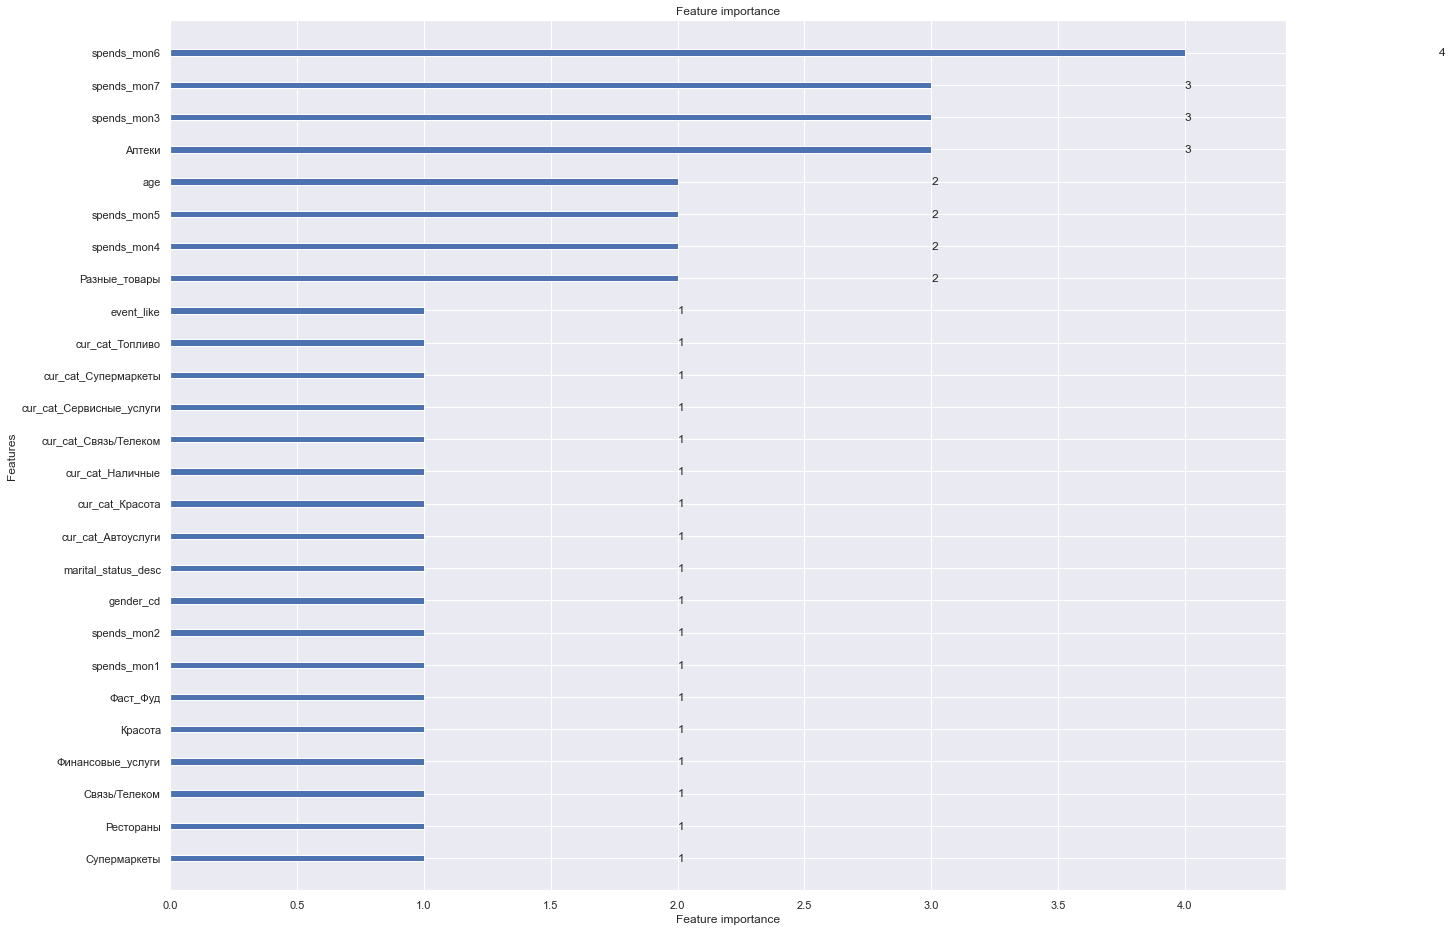

In [225]:
plot_importance(opt_model)

In [227]:
test_trans = pd.read_csv(path_data + 'data_test_transactions.csv')
print(test_trans.shape)
test_trans.head()

(432054, 8)


,party_rk,account_rk,financial_account_type_cd,transaction_dttm,transaction_type_desc,transaction_amt_rur,merchant_rk,category
0,35240,34588,2,2020-01-01,Снятие наличных,7522.0,2495767.0,Наличные
1,56472,106674,2,2020-01-01,Покупка,122.0,1456914.0,Разные товары
2,49587,52561,2,2020-01-01,Покупка,221.0,2820398.0,Транспорт
3,51277,54808,2,2020-01-01,Покупка,565.0,212573.0,Разные товары
4,9214,8502,2,2020-01-01,Покупка,189.0,2651683.0,Транспорт


In [230]:
len(list(set(test_trans.party_rk.values)))

13517